# CSE 253 Assignment 2 - Conditioned and Unconditioned Generation of Symbolic Classical Music
Submission Authors are: 
- Samvrit Srinath
- Divyam Sengar
- Venkatraman Sivaram 

This Jupyter Notebook contains an extensive analysis of the MAESTRO dataset. 

## Introduction

*Algorithmic composition* or the practice of using formal processes to create music, has been propelled by the widespread use of *generative models* in recent years. A primary distinction exists between symbolic (MIDI/concrete) generation and continuous generation (spectrogram/audio waveforms). 

The focus of this report involves creating music that based based on **symbolic mediums**, i.e. MIDI files that represent discrete musical events like notes, chords and rests. 

Furthermore we bifurcate the task of generation into two cases:

1. **Unconditioned Generation**: The model learns to generate music from scratch, without any conditioning on external features.
2. **Conditioned Generation**: The model learns to generate music based on a set of conditions. (In this case Harominzation based on a provided prefix or melody, akin to fugue generation).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import music21
from music21 import converter, note, chord, stream, tempo, key, pitch, duration, environment
import multiprocessing
from collections import Counter
from tqdm.auto import tqdm
import warnings

/home/sasrinath/.conda/envs/music-tf-pytorch/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
warnings.filterwarnings('ignore', category=FutureWarning, module='seaborn')
warnings.filterwarnings('ignore', category=UserWarning, module='matplotlib')
# music21 can be verbose with some warnings, suppress if necessary for cleanliness


pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
sns.set_theme(style="whitegrid")


DATA_DIR = Path('../data/')
MAESTRO_METADATA_FILE = DATA_DIR / 'maestro-v3.0.0.csv'
MIDI_BASE_PATH = DATA_DIR # MIDI files are in subdirectories like data/2004/, data/2006/ etc.

## MAESTRO Dataset - MIDI and Audio Edited for Synchronous Tracks and Organization

The MAESTRO dataset, aggregated and collected by the Google Magenta team (who works closely with the developers of Tensorflow), stands as a significant resource for music information retrieval and generation. 

**NOTE**: Other datasets were considered like the [Lakh Midi Dataset](https://paperswithcode.com/dataset/lakh-midi-dataset) or any of its subsets like the LMD-matched, LMD-aligned, or LMD-clean (which are on the order of 17,000) files. That being said, as we'll get into later, our focus is on classical improvisation, and while these datasets provide a much broader range of music, the lack of focus on Classical and Virtuosic pieces is a significant drawback and mismatches with our objective. 

Going back to the MAESTRO dataset, we note that these performances were captured during ten years of the International Piano-e-Competition, utilizing Yamaha Disklaviers. These instruments are concert-quality acoustic grand pianos equipped with high-precision MIDI capture systems, recording not only note onsets and offsets but also detailed performance nuances such as key strike velocities and the use of sustain, sostenuto, and una corda pedals. The "virtuosic" nature of these performances suggests a dataset rich in technically complex and expressively varied musical material. 




In [3]:
def load_maestro_metadata(file_path: Path) -> pd.DataFrame | None:
    if not file_path.exists():
        print(f"Metadata file not found: {file_path}")
        return None
    try:
        if file_path.suffix == '.csv':
            df = pd.read_csv(file_path)
        elif file_path.suffix == '.json':
            df = pd.read_json(file_path, lines=True if 'v1.0.0' in file_path.name else False)
            if 'v3.0.0.json' in file_path.name: # v3.0.0 json is not line-delimited
                 df = pd.read_json(file_path)

        else:
            print(f"Unsupported metadata file format: {file_path.suffix}")
            return None
        
        # Construct full MIDI path. MIDI files are in subdirectories named by year,
        # e.g., data/2004/MIDI-Unprocessed_SMF_02_R1_2004_01-04_ORIG_MID--AUDIO_02_R1_2004_06_Track06_wav.midi
        # The 'midi_filename' column in maestro-v3.0.0.csv already contains the year prefix.
        df['midi_filepath'] = df['midi_filename'].apply(lambda x: MIDI_BASE_PATH / x)
        return df
    except Exception as e:
        print(f"Error loading metadata from {file_path}: {e}")
        return None

maestro_df = load_maestro_metadata(MAESTRO_METADATA_FILE)

if maestro_df is not None:
    print("MAESTRO Metadata Loaded Successfully:")
    print(maestro_df.head())
    print("\nDataFrame Info:")
    maestro_df.info()
    print(f"\nTotal pieces in metadata: {len(maestro_df)}")
else:
    print("Failed to load MAESTRO metadata. Some metadata-driven EDA parts will be skipped.")
    # Initialize an empty DataFrame to prevent errors in later cells if they expect maestro_df
    raise ValueError("Failed to load MAESTRO metadata. Some metadata-driven EDA parts will be skipped.")

MAESTRO Metadata Loaded Successfully:
   canonical_composer                canonical_title       split  year                                      midi_filename                                     audio_filename    duration                                      midi_filepath
0          Alban Berg                   Sonata Op. 1       train  2018  2018/MIDI-Unprocessed_Chamber3_MID--AUDIO_10_R...  2018/MIDI-Unprocessed_Chamber3_MID--AUDIO_10_R...  698.661160  ../data/2018/MIDI-Unprocessed_Chamber3_MID--AU...
1          Alban Berg                   Sonata Op. 1       train  2008  2008/MIDI-Unprocessed_03_R2_2008_01-03_ORIG_MI...  2008/MIDI-Unprocessed_03_R2_2008_01-03_ORIG_MI...  759.518471  ../data/2008/MIDI-Unprocessed_03_R2_2008_01-03...
2          Alban Berg                   Sonata Op. 1       train  2017  2017/MIDI-Unprocessed_066_PIANO066_MID--AUDIO-...  2017/MIDI-Unprocessed_066_PIANO066_MID--AUDIO-...  464.649433  ../data/2017/MIDI-Unprocessed_066_PIANO066_MID...
3  Alexander Scria

In [4]:
maestro_df.head()

,canonical_composer,canonical_title,split,year,midi_filename,audio_filename,duration,midi_filepath
0,Alban Berg,Sonata Op. 1,train,2018,2018/MIDI-Unprocessed_Chamber3_MID--AUDIO_10_R...,2018/MIDI-Unprocessed_Chamber3_MID--AUDIO_10_R...,698.661160,../data/2018/MIDI-Unprocessed_Chamber3_MID--AU...
1,Alban Berg,Sonata Op. 1,train,2008,2008/MIDI-Unprocessed_03_R2_2008_01-03_ORIG_MI...,2008/MIDI-Unprocessed_03_R2_2008_01-03_ORIG_MI...,759.518471,../data/2008/MIDI-Unprocessed_03_R2_2008_01-03...
2,Alban Berg,Sonata Op. 1,train,2017,2017/MIDI-Unprocessed_066_PIANO066_MID--AUDIO-...,2017/MIDI-Unprocessed_066_PIANO066_MID--AUDIO-...,464.649433,../data/2017/MIDI-Unprocessed_066_PIANO066_MID...
3,Alexander Scriabin,"24 Preludes Op. 11, No. 13-24",train,2004,2004/MIDI-Unprocessed_XP_21_R1_2004_01_ORIG_MI...,2004/MIDI-Unprocessed_XP_21_R1_2004_01_ORIG_MI...,872.640588,../data/2004/MIDI-Unprocessed_XP_21_R1_2004_01...
4,Alexander Scriabin,"3 Etudes, Op. 65",validation,2006,2006/MIDI-Unprocessed_17_R1_2006_01-06_ORIG_MI...,2006/MIDI-Unprocessed_17_R1_2006_01-06_ORIG_MI...,397.857508,../data/2006/MIDI-Unprocessed_17_R1_2006_01-06...


## Exploratory Data Analysis

**We will ensemble the Data Analysis for both Tasks 1 and Tasks 2 here, using high level functions to avoid code duplication and deriving semantic meaning from the dataset that will be used in both tasks**. 
 <p style="color: red;"><b>FOR REVIEWERS: TASK 1 AND TASK 2 EXPLORATORY DATA ANALYSIS ARE PRESENT IN THE CELLS BELOW</b></p>


### Tools, Frameworks and Approach
We will be using `music21`, the open source python library for music information retrieval, provided by the MIT Media Lab. Its object-oriented structure provides granular access to musical elements such as notes, chords, rests, key signatures, time signatures, and metrical structures. We can extract features from the MIDI files and use them to train and tune our tokenization approaches, and feature engineer our conditioned generation approaches. 

We will also be using the high level CSV that the MAESTRO dataset provides, which contains metadata about each piece such as the composer, genre, key, and duration, as well as what train/test/val split the piece belongs to. 

*Notes about the dataset metadata itself*
The standardization of canonical_composer is beneficial, allowing for reliable grouping and analysis by composer. However, the canonical_title field is not guaranteed to be uniformly standardized. This implies that analyses requiring the identification of unique musical works (as opposed to unique performances) might necessitate more sophisticated title matching or manual curation if precise piece-level grouping is critical.

The MAESTRO dataset, particularly version 3.0.0, has undergone curation to improve data purity. For instance, some erroneous recordings that included non-piano accompaniments (e.g., string quartets) present in earlier versions were removed in v3.0.0. This curation enhances confidence that the MIDI files predominantly represent solo piano performances. This focus simplifies modeling assumptions, as it reduces the need for explicit instrument separation within the symbolic data, aligning well with the goal of generating solo piano music.

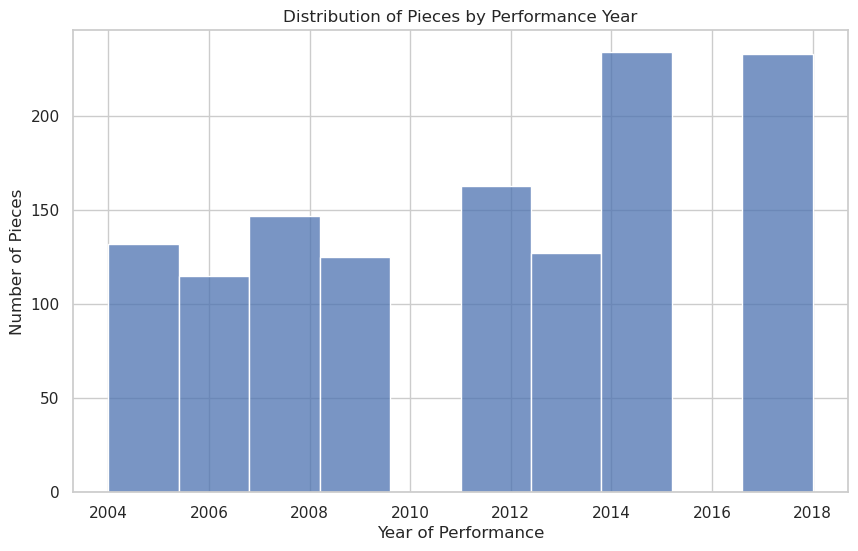

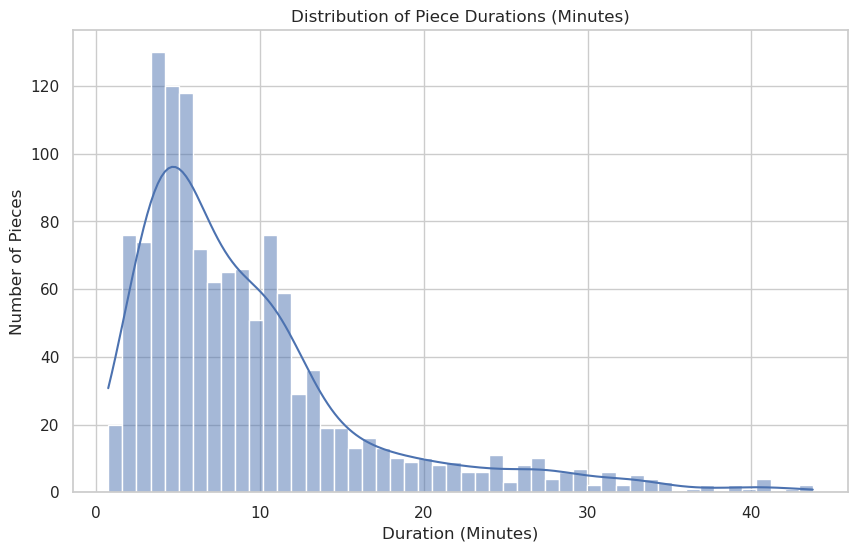

/tmp/ipykernel_26531/1038545557.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=composer_counts_to_plot.index, y=composer_counts_to_plot.values, palette="viridis")


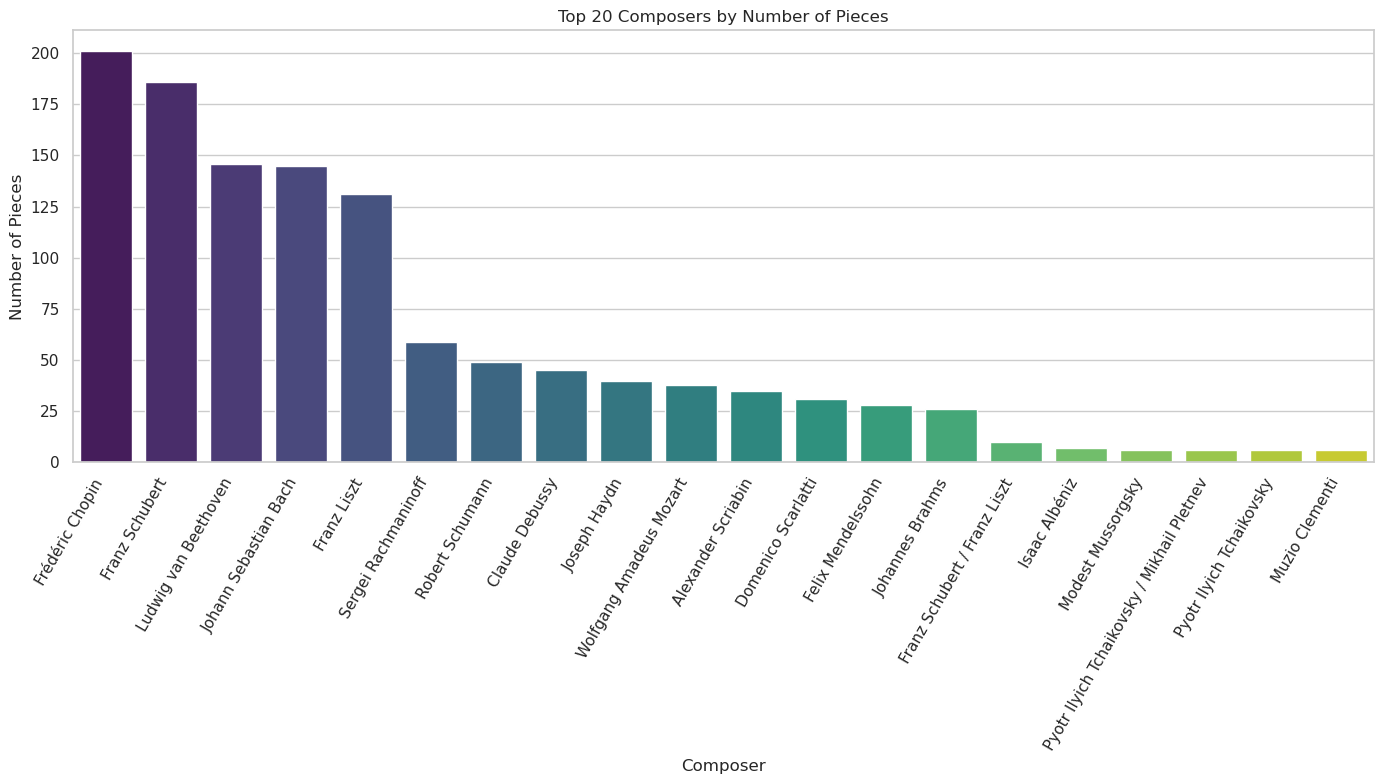


Summary statistics for piece duration (seconds):
count    1276.000000
mean      560.463595
std       443.057431
min        45.155208
25%       261.981576
50%       429.168241
75%       685.018817
max      2624.663508
Name: duration, dtype: float64


In [5]:
if maestro_df is not None and not maestro_df.empty:
    plt.figure(figsize=(10, 6))
    sns.histplot(maestro_df['year'], 
                 bins=len(maestro_df['year'].unique()) if maestro_df['year'].nunique() > 0 else 1, 
                 kde=False)
    plt.title('Distribution of Pieces by Performance Year')
    plt.xlabel('Year of Performance')
    plt.ylabel('Number of Pieces')
    plt.show()

    plt.figure(figsize=(10, 6))
    sns.histplot(maestro_df['duration'] / 60, bins=50, kde=True) # Duration in minutes
    plt.title('Distribution of Piece Durations (Minutes)')
    plt.xlabel('Duration (Minutes)')
    plt.ylabel('Number of Pieces')
    plt.show()

    plt.figure(figsize=(14, 8))
    top_n_composers = 20 
    composer_counts = maestro_df['canonical_composer'].value_counts()
    composer_counts_to_plot = composer_counts.nlargest(top_n_composers)
    
    sns.barplot(x=composer_counts_to_plot.index, y=composer_counts_to_plot.values, palette="viridis")
    plt.title(f'Top {len(composer_counts_to_plot)} Composers by Number of Pieces')
    plt.xlabel('Composer')
    plt.ylabel('Number of Pieces')
    plt.xticks(rotation=60, ha='right')
    plt.tight_layout()
    plt.show()
    print("\nSummary statistics for piece duration (seconds):")
    print(maestro_df['duration'].describe())
else:
    print("maestro_df is None or empty, skipping metadata visualizations.")

### Composer + Duration Analysis

Many of the virtuosic performances begin in 2018, which lends to the fact that this is the *3rd* iteration of the dataset, and the curation efforts have been successful in removing non-piano accompaniments. This improves the quality of single generative efforts, as our music now emulates what a human soloist would play. 

Next, we can see that the distribution of piece durations is right skewed, with a median of 3 minutes and a mean of 4.5 minutes. This is a good sign, as it means that the dataset is not overly dominated by short pieces, which would make it difficult for a model to learn. That being said, there are many outliers, some to the order of 40 minutes, which makes tokenization and processing a bit more difficult. 

Finaly, Composers are highly dominated by **Romantic Period Composers** with the likes of Chopin, Schubert, Liszt, Rachmanioff, Debussy and more. We find it shocking that individuals like Mozart, Mendelssohn, and Tchaikovsky are not featured more prominently, which leads us to believe that the curation process may have been biased towards Romantic and Impressionist composers. 

That being said, Beethoven is featured prominently, which is a good sign, and could lead to more fugal generation/improvisation.

## Music 21 Processing
We have an external `midi_processing.py` file that contains the code for processing the MIDI files. We will use this to extract the features that we need for our analysis. 

What we primarily look at is the following features: 
- Key Signatures
- Pitch Content
- Rhythmic Content
- Dynamics (Velocity)
- Basic Harmonic Content
---

### A. Feature Extraction Functions

Each function operates on a `music21.stream.Score` object, typically parsed from a MIDI file. These functions return dictionaries of numerical or categorical features characterizing different musical dimensions:

#### 1. Key Features

`extract_key_features_from_score(score)`

* Estimates the global key of the piece using `score.analyze('key')`.
* Returns:

  * `key_tonic`: Tonic note (e.g., “C”, “G#”).
  * `key_mode`: Mode (“major”, “minor”, etc.).
  * `key_confidence`: Correlation coefficient of the key estimation (if available).

#### 2. Pitch Features

`extract_pitch_features_from_score(score)`

* Analyzes pitch content from notes and chords.
* Returns:

  * Number of notes.
  * Statistics over pitch values (min, max, mean, median, std, range), where pitch is measured in semitone units (MIDI pitch space).

#### 3. Rhythmic Features

`extract_rhythmic_features_from_score(score)`

* Computes statistics over note and rest durations, as well as inter-onset intervals (IOIs).
* Returns:

  * Duration statistics: mean, median, std, count.
  * IOI statistics: mean, median, std, count.
  * Samples of durations and IOIs (first 1000 entries).

#### 4. Tempo Features

`extract_tempo_features_from_score(score)`

* Extracts tempo markings (BPM) from the score.
* Returns:

  * `initial_tempo_bpm`: First detected tempo marking.
  * `mean_tempo_bpm`: Average tempo.
  * `num_distinct_tempos`: Count of unique tempo changes.
  * Sample of tempo changes (up to 10 values).

#### 5. Polyphony Features

`extract_polyphony_features_from_score(score)`

* Estimates the level of polyphony using a chordified version of the score.
* Returns:

  * `avg_polyphony`, `max_polyphony`, `median_polyphony`: Statistical measures of simultaneous pitches.
  * `polyphony_levels_sample`: First 1000 values of polyphony per note/chord.

#### 6. Master Function: MIDI File Processor

`process_single_midi_file(filepath)`

* Loads and processes a single MIDI file with `converter.parse`.
* Calls all the above extraction functions and aggregates the results.
* Returns:

  * Extracted features dictionary, including the file name and total duration in quarter lengths.

---

### B. Core `music21` Concepts Used

The extraction pipeline relies on several key `music21` objects and methods:

* **`converter.parse(filepath)`**: Parses a MIDI file into a `Score` object.
* **`Stream.flat`** and **`Stream.flatten().notesAndRests`**: Used for accessing a linear sequence of musical events.
* **`Note`, `Chord`, and `Rest`**: Represent individual musical elements. Important attributes include:

  * `pitch.ps` (pitch in semitones)
  * `duration.quarterLength`
  * `offset` (onset time)
  * `pitches` (for chords)
* **`MetronomeMark`**: Represents tempo indications (BPM).
* **`chordify()`**: Reduces multi-stream scores to a sequence of vertical sonorities for polyphonic analysis.

---

### C. Feature Caching

To reduce redundant computation:

* Extracted features are saved to disk using Python’s `pickle` module.
* These pickled files are stored in a dedicated directory, such as `data/music21_cache/` or `data/processed_features/`.
* On subsequent runs, the pipeline can load from cache instead of re-processing MIDI files.

---

### D. Focused Feature Set for EDA

The pipeline emphasizes a core set of interpretable musical features:

* **Key/Tonality**: Tonics, modes, and confidence of global key estimation.
* **Pitch**: Note count, pitch range, average pitch, and pitch distribution.
* **Rhythm**: Duration and IOI patterns, tempo variations.
* **Polyphony**: Texture density and simultaneity across the score.

These features support efficient analysis and modeling of symbolic music data using a consistent, interpretable framework.




In [ ]:
from midi_processing import process_single_midi_file
from concurrent.futures import ProcessPoolExecutor
# as an side this step took nearly 3 hours, so we cached for future analysis. 
with ProcessPoolExecutor(max_workers=multiprocessing.cpu_count() * 8) as executor:
    results = list(tqdm(executor.map(process_single_midi_file, maestro_df['midi_filepath']), total=len(maestro_df)))

results_df = pd.DataFrame(results)

  0%|          | 0/1276 [00:36<?, ?it/s]


In [ ]:
results_df.head()

In [ ]:
if maestro_df is not None and not maestro_df.empty and not results_df.empty:
    maestro_df['midi_filename_basename'] = maestro_df['midi_filename'].apply(lambda x: Path(x).name)
    results_df.rename(columns={'midi_filename_processed': 'midi_filename_basename'}, inplace=True)
    
    combined_df = pd.merge(maestro_df, results_df, on='midi_filename_basename', how='inner', suffixes=('_meta', '_extracted'))
    print(f"Combined DataFrame after merging with metadata (shape: {combined_df.shape}):")
elif not results_df.empty:
    combined_df = results_df
    print("Using features extracted directly from MIDI files (metadata not merged).")
    print(f"Features DataFrame shape: {combined_df.shape}")
else:
    combined_df = pd.DataFrame() 
    print("Resulting combined_df is empty.")


In [6]:
combined_df = pd.read_csv('combined_df.csv') 
combined_df.head()

,canonical_composer,canonical_title,split,year,midi_filename,audio_filename,duration,midi_filepath,midi_filename_basename,error,truncated_to_one_minute,key_tonic,key_mode,key_confidence,num_notes,pitch_min,pitch_max,pitch_mean,pitch_median,pitch_std,pitch_range,avg_duration_ql,median_duration_ql,std_duration_ql,num_rhythmic_elements,avg_ioi_ql,median_ioi_ql,std_ioi_ql,num_iois,durations_ql_sample,iois_ql_sample,initial_tempo_bpm,mean_tempo_bpm,num_distinct_tempos,all_tempos_bpm_sample,avg_polyphony,max_polyphony,median_polyphony,polyphony_levels_sample,total_quarter_length
0,Alban Berg,Sonata Op. 1,train,2018,2018/MIDI-Unprocessed_Chamber3_MID--AUDIO_10_R...,2018/MIDI-Unprocessed_Chamber3_MID--AUDIO_10_R...,698.661160,../data/2018/MIDI-Unprocessed_Chamber3_MID--AU...,MIDI-Unprocessed_Chamber3_MID--AUDIO_10_R3_201...,NaN,True,D,major,0.908736,1705,28.0,94.0,63.992375,64.0,11.892502,66.0,0.763874,0.494792,0.818971,2908,0.375927,0.231771,0.479994,1300,"[1.9661458333333333, 3.5677083333333335, 1.653...","[1.6015625, 0.7265625, 0.013020833333333334, 0...",120.0,120.0,1,[120],2.775257,7,3.0,"[1, 2, 1, 1, 2, 3, 4, 3, 2, 1, 1, 2, 1, 1, 2, ...",490.773438
1,Alban Berg,Sonata Op. 1,train,2008,2008/MIDI-Unprocessed_03_R2_2008_01-03_ORIG_MI...,2008/MIDI-Unprocessed_03_R2_2008_01-03_ORIG_MI...,759.518471,../data/2008/MIDI-Unprocessed_03_R2_2008_01-03...,MIDI-Unprocessed_03_R2_2008_01-03_ORIG_MID--AU...,NaN,True,D,major,0.755801,1716,28.0,94.0,64.054196,64.0,11.912902,66.0,0.854507,0.578125,0.865533,2819,0.401947,0.290365,0.488696,1222,"[2.0286458333333335, 3.390625, 1.7942708333333...","[1.3619791666666665, 0.609375, 0.1223958333333...",120.0,120.0,1,[120],3.145567,8,3.0,"[1, 2, 1, 1, 2, 4, 5, 4, 5, 4, 3, 1, 1, 2, 4, ...",493.333333
2,Alban Berg,Sonata Op. 1,train,2017,2017/MIDI-Unprocessed_066_PIANO066_MID--AUDIO-...,2017/MIDI-Unprocessed_066_PIANO066_MID--AUDIO-...,464.649433,../data/2017/MIDI-Unprocessed_066_PIANO066_MID...,MIDI-Unprocessed_066_PIANO066_MID--AUDIO-split...,NaN,True,D,major,0.594818,2097,27.0,98.0,65.442060,65.0,13.420978,71.0,0.648420,0.414583,0.704076,3437,0.312023,0.238542,0.331023,1546,"[0.5479166666666667, 1.9479166666666667, 2.552...","[1.4, 0.58125, 0.022916666666666665, 0.0458333...",120.0,120.0,1,[120],2.878676,8,3.0,"[1, 2, 1, 2, 3, 4, 5, 4, 4, 5, 4, 3, 2, 1, 2, ...",482.947917
3,Alexander Scriabin,"24 Preludes Op. 11, No. 13-24",train,2004,2004/MIDI-Unprocessed_XP_21_R1_2004_01_ORIG_MI...,2004/MIDI-Unprocessed_XP_21_R1_2004_01_ORIG_MI...,872.640588,../data/2004/MIDI-Unprocessed_XP_21_R1_2004_01...,MIDI-Unprocessed_XP_21_R1_2004_01_ORIG_MID--AU...,NaN,True,E-,minor,0.897177,1660,27.0,95.0,61.025904,61.0,12.216222,68.0,0.752927,0.456250,0.863563,2701,0.398261,0.191667,0.921300,1228,"[2.075, 2.160416666666667, 2.2083333333333335,...","[0.08541666666666667, 0.04791666666666667, 1.2...",120.0,120.0,1,[120],3.008513,7,3.0,"[1, 2, 3, 4, 4, 5, 4, 5, 4, 3, 4, 3, 4, 3, 2, ...",491.170833
4,Alexander Scriabin,"3 Etudes, Op. 65",validation,2006,2006/MIDI-Unprocessed_17_R1_2006_01-06_ORIG_MI...,2006/MIDI-Unprocessed_17_R1_2006_01-06_ORIG_MI...,397.857508,../data/2006/MIDI-Unprocessed_17_R1_2006_01-06...,MIDI-Unprocessed_17_R1_2006_01-06_ORIG_MID--AU...,NaN,True,C,major,0.359056,2089,24.0,98.0,68.848253,68.0,13.603017,74.0,0.503482,0.205729,0.769518,3217,0.328474,0.208333,0.620227,1501,"[1.890625, 2.0416666666666665, 0.2317708333333...","[0.15104166666666652, 0.5755208333333335, 0.34...",120.0,120.0,1,[120],2.111693,7,2.0,"[3, 4, 1, 1, 2, 4, 1, 2, 1, 2, 2, 2, 2, 3, 3, ...",496.281250


In [7]:
combined_df.to_csv('combined_df.csv', index=False) # cache results

### Key Distribution Analysis

/tmp/ipykernel_26531/931073276.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=key_counts.index, y=key_counts.values, palette="crest")


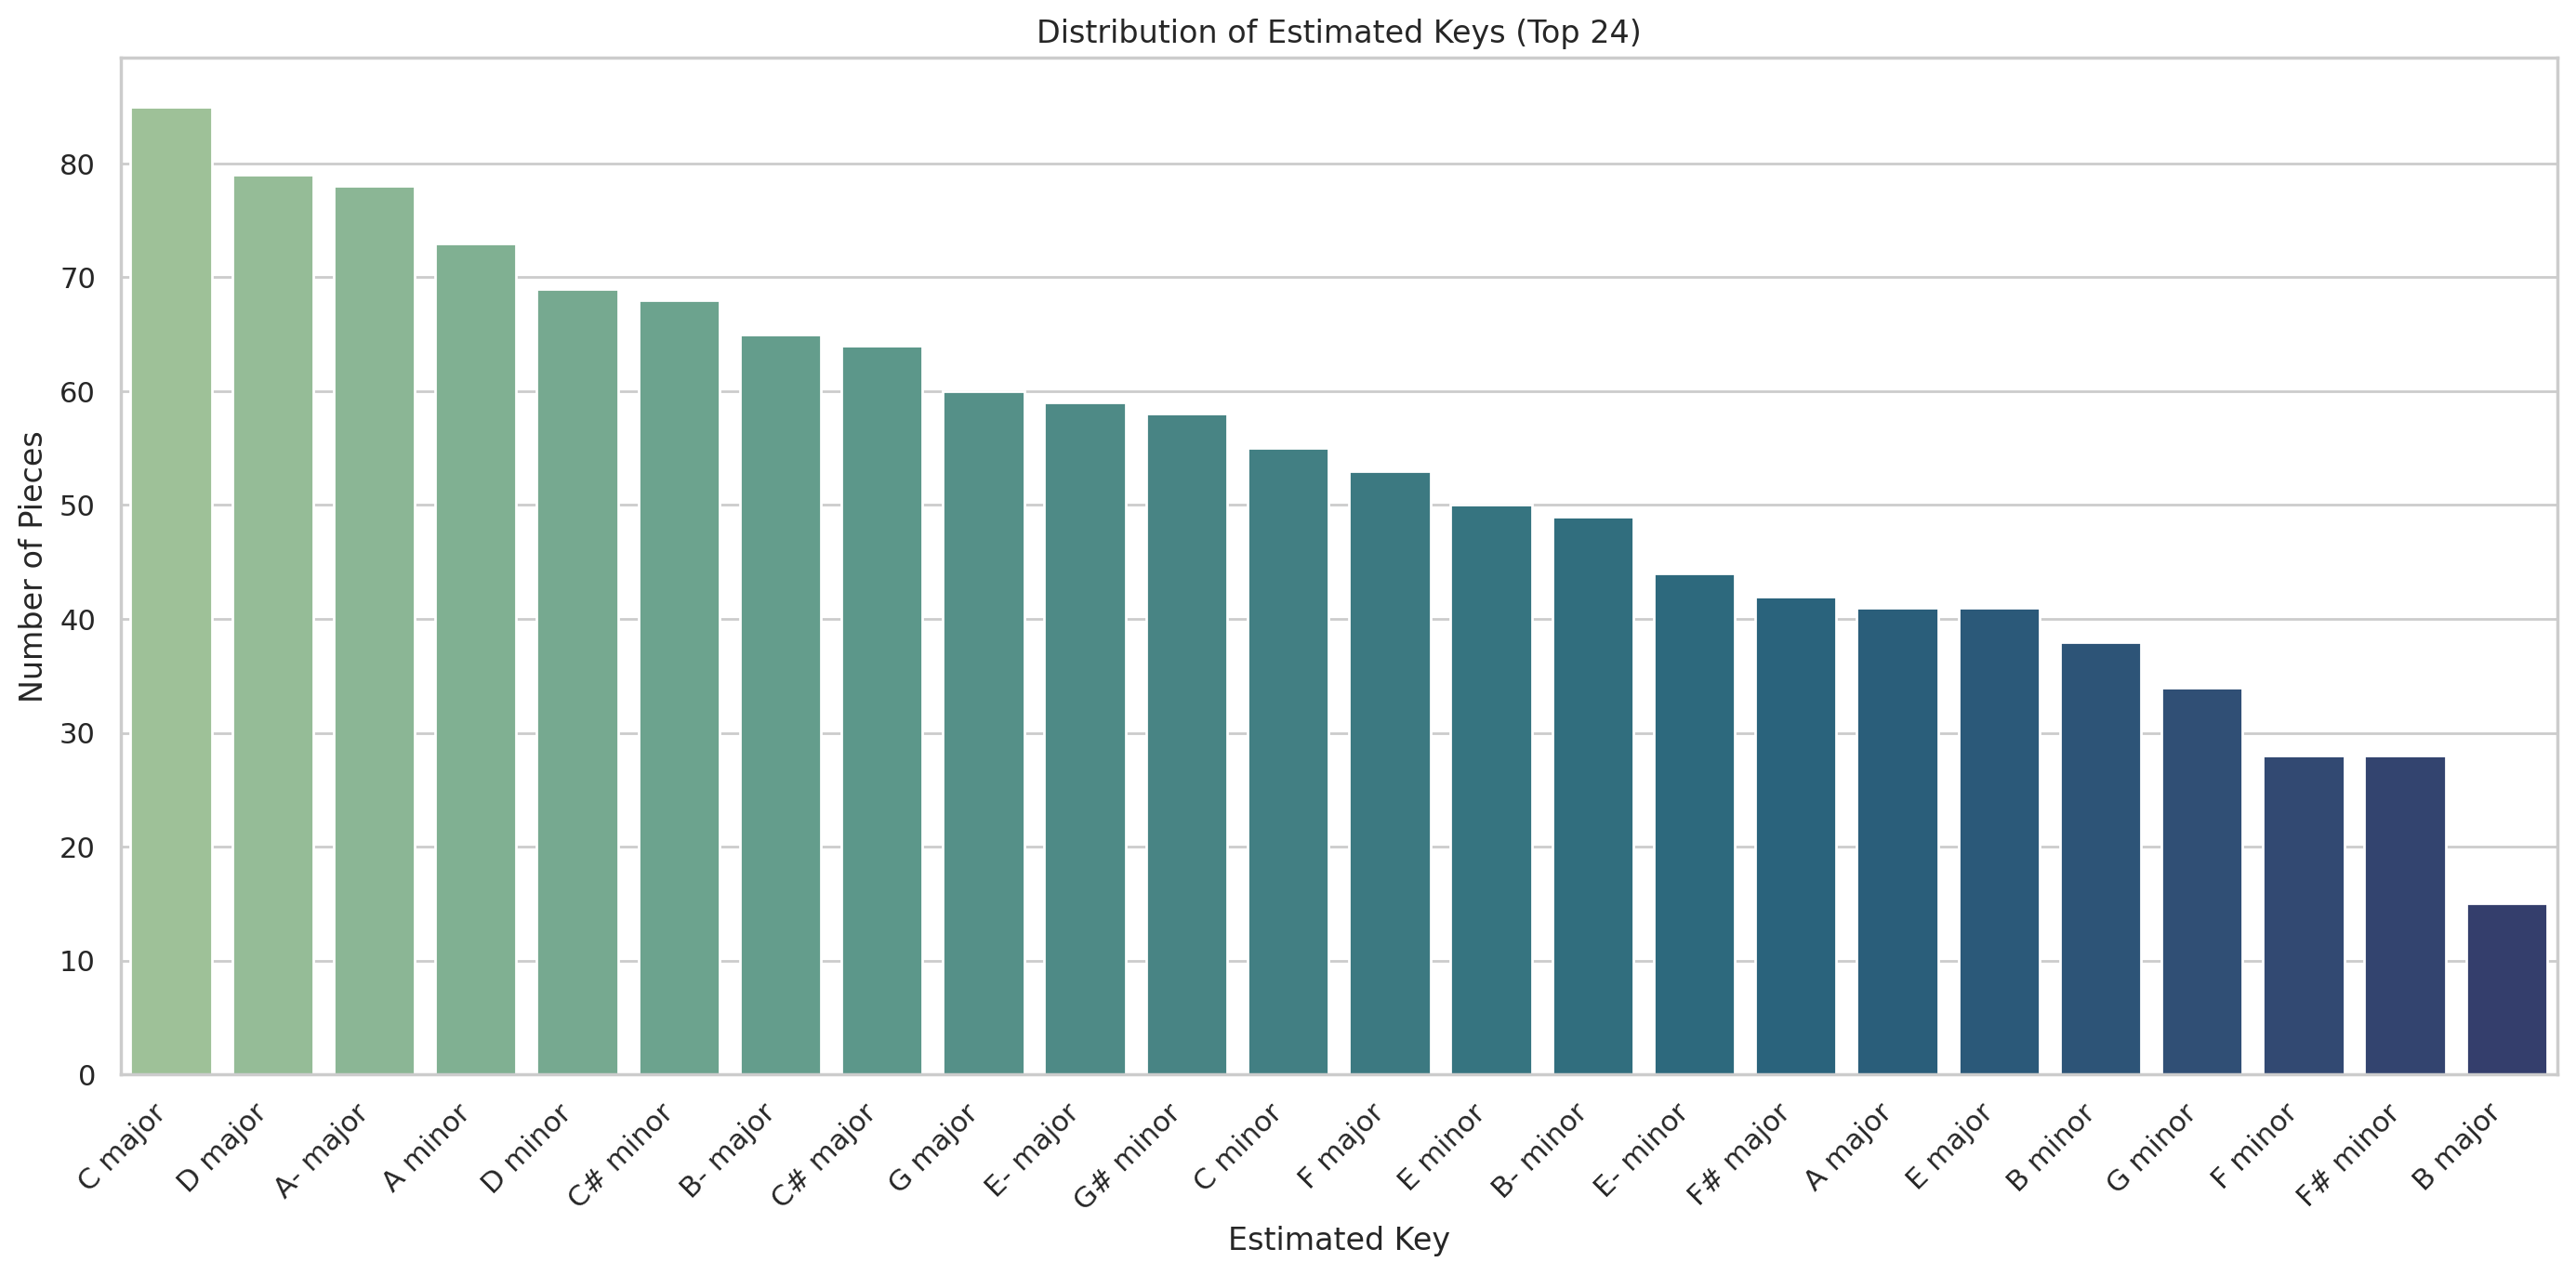

/tmp/ipykernel_26531/931073276.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=mode_counts.index, y=mode_counts.values, palette="pastel")


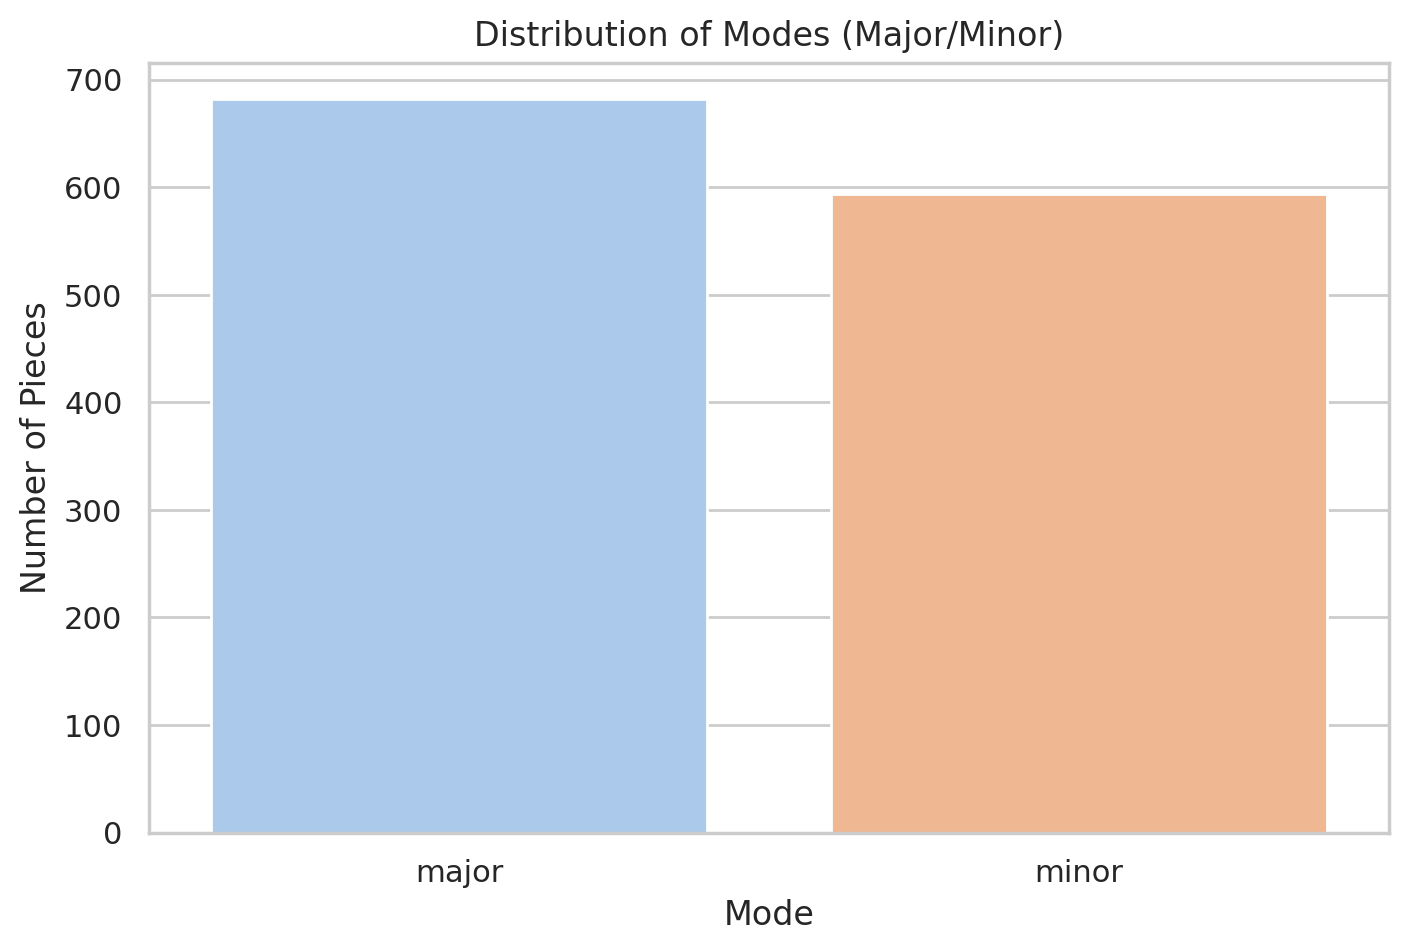


Frequency of Top Estimated Keys:
estimated_key_full
C major     85
D major     79
A- major    78
A minor     73
D minor     69
C# minor    68
B- major    65
C# major    64
G major     60
E- major    59
G# minor    58
C minor     55
F major     53
E minor     50
B- minor    49
E- minor    44
F# major    42
A major     41
E major     41
B minor     38
G minor     34
F minor     28
F# minor    28
B major     15
Name: count, dtype: int64

Frequency of Modes:
key_mode_str
major    682
minor    594
Name: count, dtype: int64

Table: Frequency of Top N Estimated Keys
Estimated Key  Count  Percentage
      C major     85    6.661442
      D major     79    6.191223
     A- major     78    6.112853
      A minor     73    5.721003
      D minor     69    5.407524
     C# minor     68    5.329154
     B- major     65    5.094044
     C# major     64    5.015674
      G major     60    4.702194
     E- major     59    4.623824
     G# minor     58    4.545455
      C minor     55    4.310345
    

In [8]:
if not combined_df.empty and 'key_tonic' in combined_df.columns and 'key_mode' in combined_df.columns:
    combined_df['key_tonic_str'] = combined_df['key_tonic'].astype(str).fillna('Unknown')
    combined_df['key_mode_str'] = combined_df['key_mode'].astype(str).fillna('')
    
    combined_df['estimated_key_full'] = combined_df['key_tonic_str'] + ' ' + combined_df['key_mode_str']
    combined_df['estimated_key_full'] = combined_df['estimated_key_full'].str.replace('Unknown ', 'Unknown', regex=False).str.strip()

    valid_keys_df = combined_df[~combined_df['estimated_key_full'].isin(['Unknown', 'None None'])]

    if not valid_keys_df.empty:
        plt.figure(figsize=(14, 7))
        key_counts = valid_keys_df['estimated_key_full'].value_counts().nlargest(24)
        sns.barplot(x=key_counts.index, y=key_counts.values, palette="crest")
        plt.title('Distribution of Estimated Keys (Top 24)')
        plt.xlabel('Estimated Key')
        plt.ylabel('Number of Pieces')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

        plt.figure(figsize=(8, 5))
        mode_counts = valid_keys_df['key_mode_str'].value_counts()
        if 'major' not in mode_counts.index and 'minor' in mode_counts.index : mode_counts.loc['major'] = 0
        if 'minor' not in mode_counts.index and 'major' in mode_counts.index : mode_counts.loc['minor'] = 0
        mode_counts = mode_counts.sort_index()

        sns.barplot(x=mode_counts.index, y=mode_counts.values, palette="pastel")
        plt.title('Distribution of Modes (Major/Minor)')
        plt.xlabel('Mode')
        plt.ylabel('Number of Pieces')
        plt.show()

        print("\nFrequency of Top Estimated Keys:")
        print(key_counts)
        print("\nFrequency of Modes:")
        print(mode_counts)
        
        key_freq_table_data = key_counts.reset_index()
        key_freq_table_data.columns = ['Estimated Key', 'Count']
        key_freq_table_data['Percentage'] = (key_freq_table_data['Count'] / len(valid_keys_df)) * 100
        print("\nTable: Frequency of Top N Estimated Keys")
        print(key_freq_table_data.to_string(index=False))

    else:
        print("No valid key analysis results to display.")
else:
    print("Key features ('key_tonic', 'key_mode') not available in combined_df for analysis.")

Ironically, `A-/G# Major` was one of the most common keys in the dataset, which is a bit of a surprise. That being said, C Major and D Major, D minor and A minor were also quite common and expected. Roughly, there was a 1.5: 1 ratio of major to minor keys in the dataset.

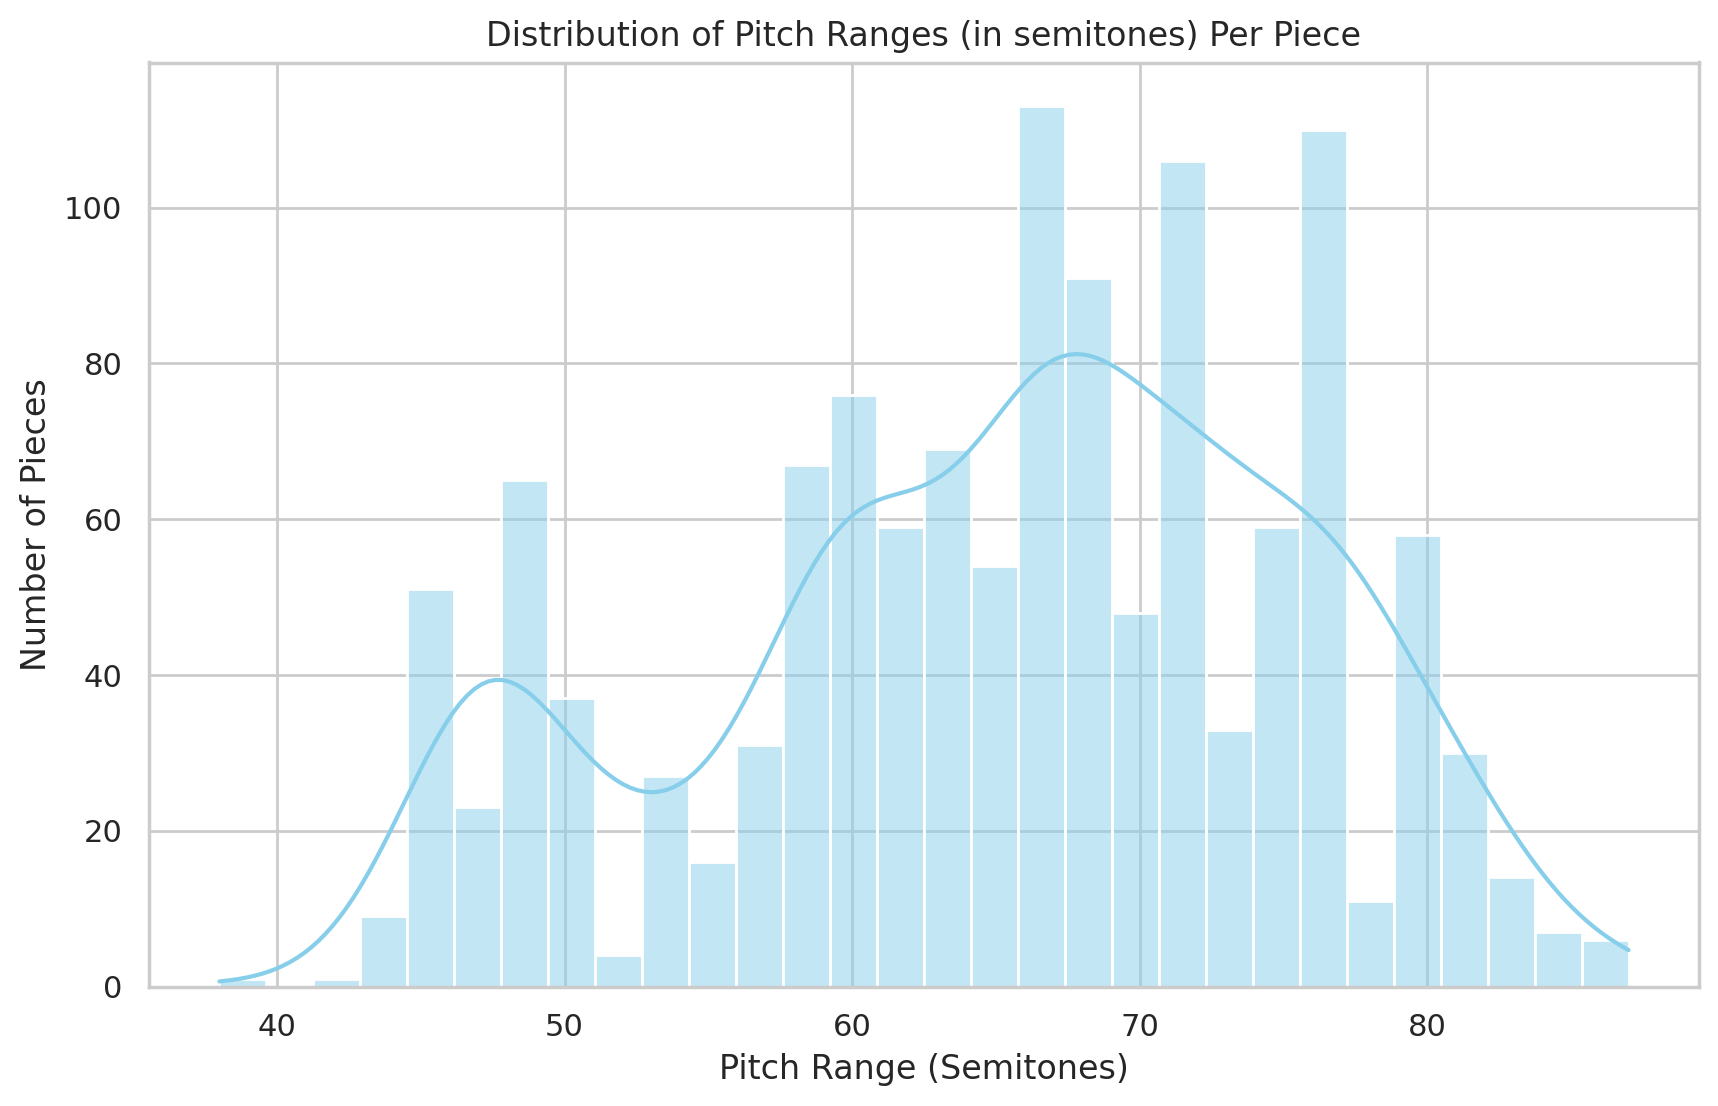

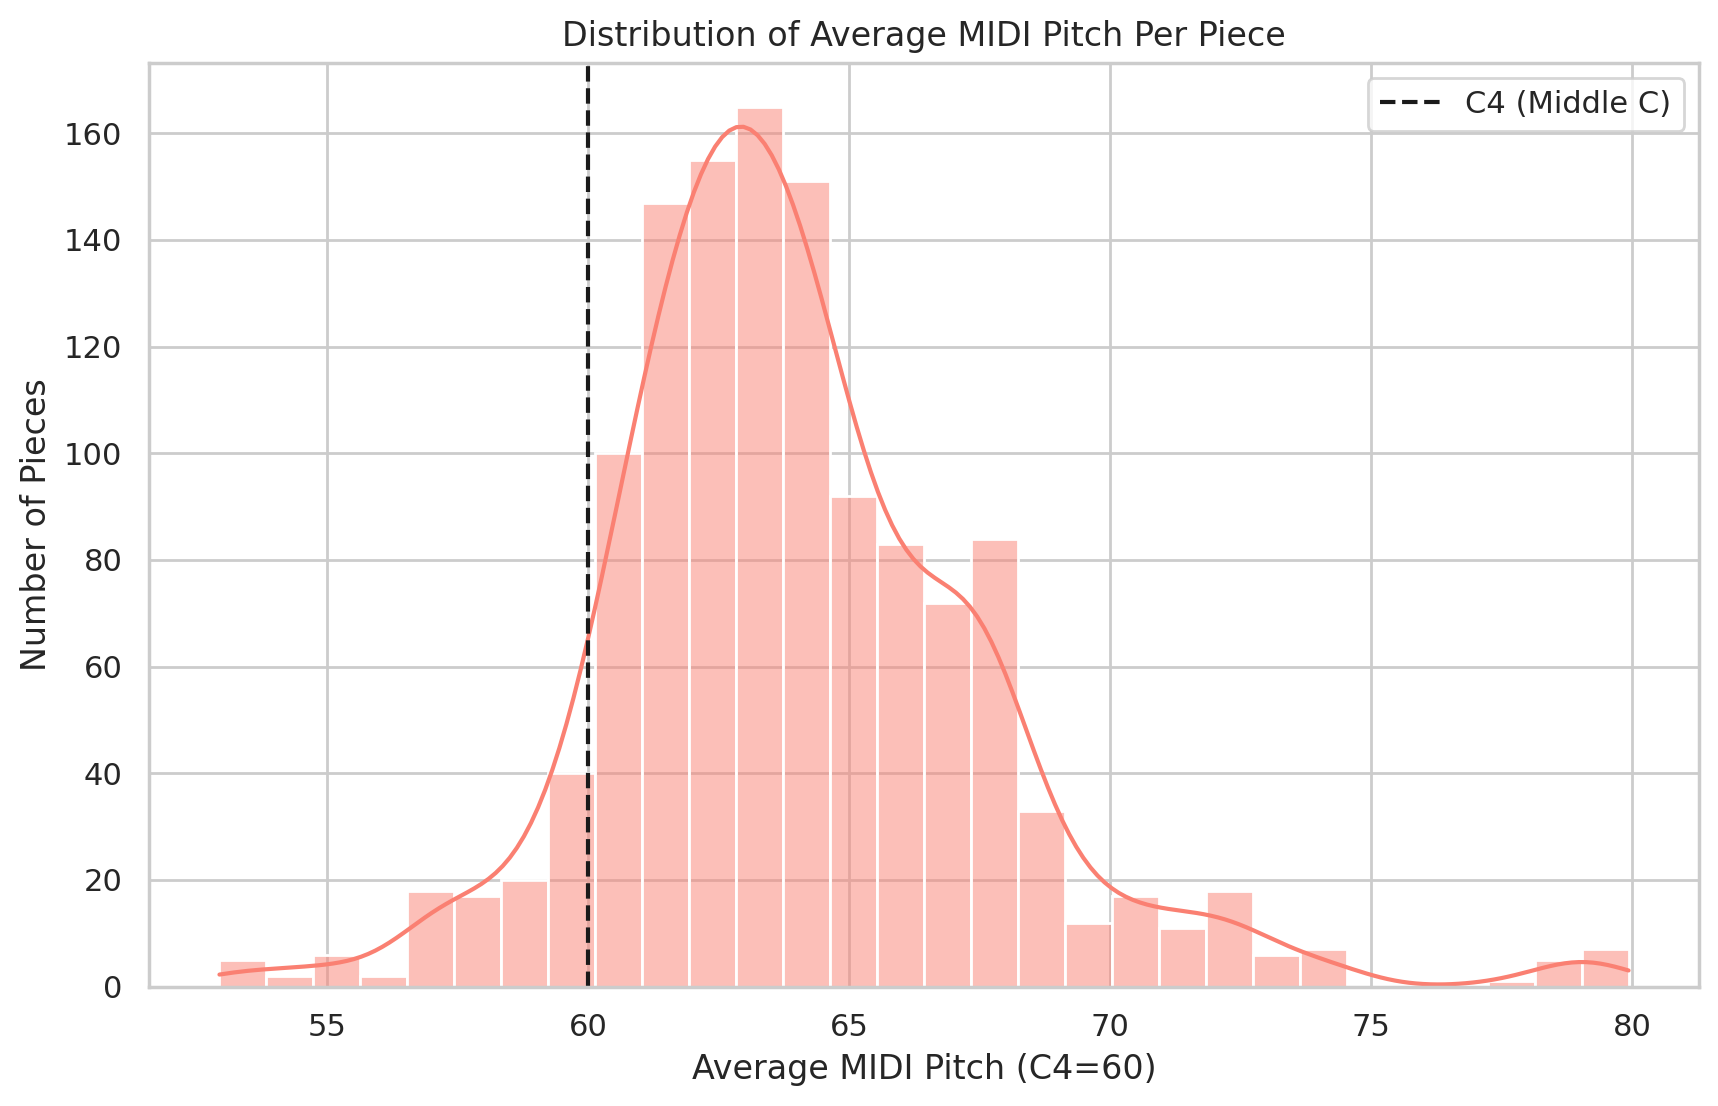

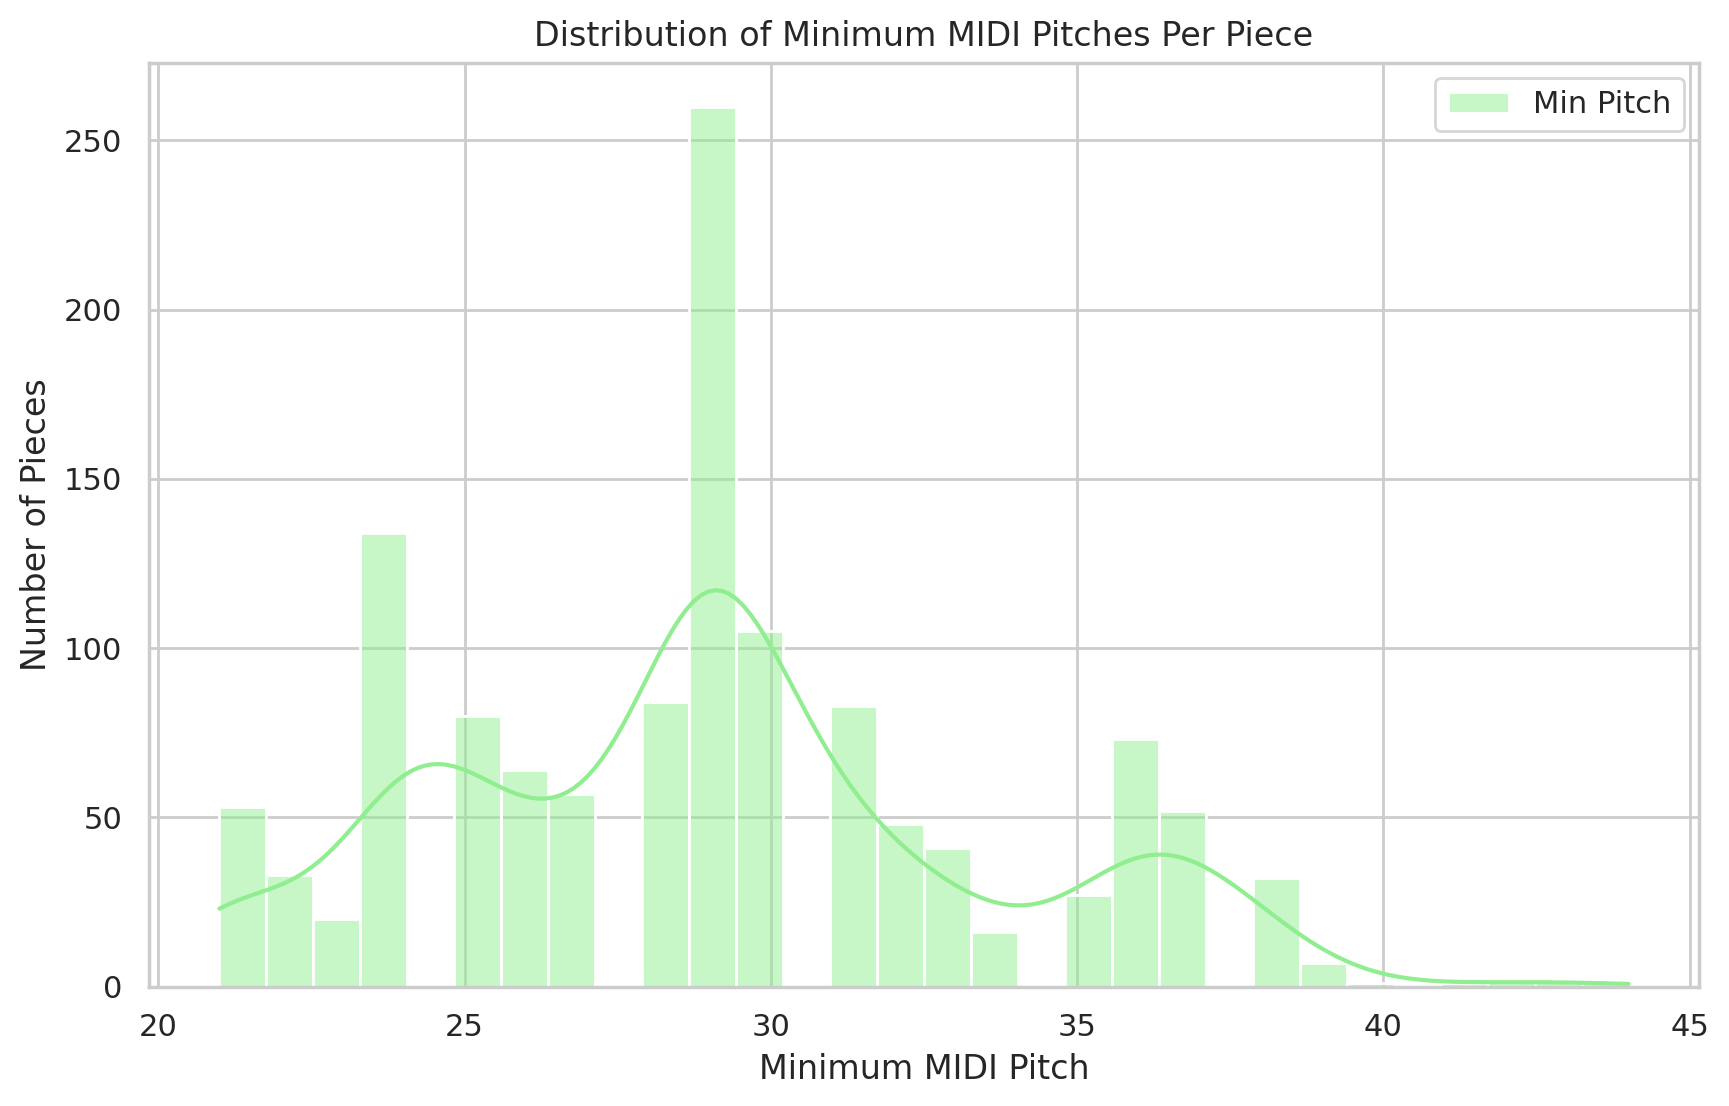

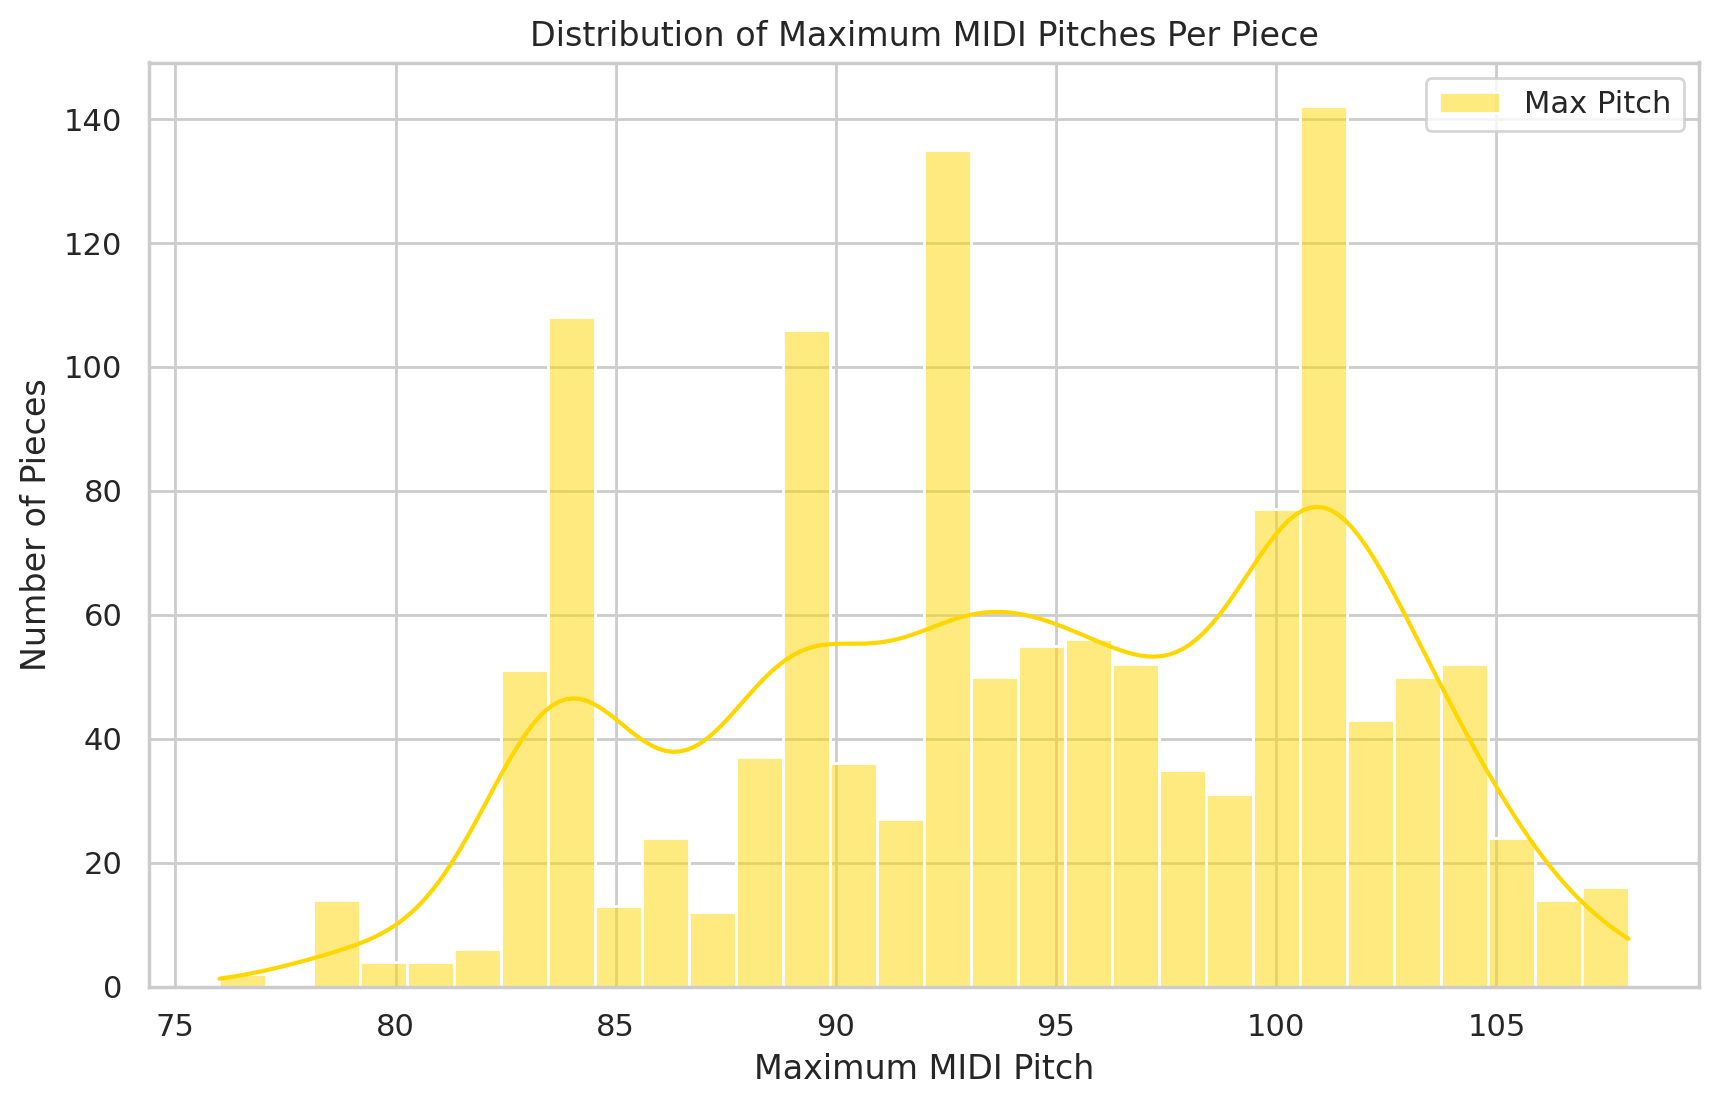


Summary statistics for per-piece pitch features:
         num_notes    pitch_min    pitch_max   pitch_mean  pitch_median    pitch_std  pitch_range
count  1276.000000  1276.000000  1276.000000  1276.000000   1276.000000  1276.000000  1276.000000
mean   2464.387147    29.033699    94.318182    63.970801     64.442398    12.644200    65.284483
std     803.714169     4.477355     7.023927     3.615645      3.961631     2.091260    10.257460
min     188.000000    21.000000    76.000000    52.942044     49.000000     7.941835    38.000000
25%    1897.750000    25.000000    89.000000    61.798825     62.000000    11.069191    59.000000
50%    2393.500000    29.000000    95.000000    63.490695     64.000000    12.449552    67.000000
75%    2963.750000    31.000000   101.000000    65.856407     67.000000    14.171521    73.000000
max    5631.000000    44.000000   108.000000    79.924378     81.000000    19.087783    87.000000

Table: Summary Statistics for Per-Piece Pitch Features
         num

In [9]:
if not combined_df.empty and 'pitch_min' in combined_df.columns and combined_df['pitch_min'].notna().all():

    if 'pitch_range' in combined_df.columns and combined_df['pitch_range'].notna().any():
        plt.figure(figsize=(10, 6))
        sns.histplot(combined_df['pitch_range'].dropna().astype(float), bins=30, kde=True, color="skyblue")
        plt.title('Distribution of Pitch Ranges (in semitones) Per Piece')
        plt.xlabel('Pitch Range (Semitones)')
        plt.ylabel('Number of Pieces')
        plt.show()

    if 'pitch_mean' in combined_df.columns and combined_df['pitch_mean'].notna().any():
        plt.figure(figsize=(10, 6))
        sns.histplot(combined_df['pitch_mean'].dropna().astype(float), bins=30, kde=True, color="salmon")
        plt.title('Distribution of Average MIDI Pitch Per Piece')
        plt.xlabel('Average MIDI Pitch (C4=60)')
        plt.ylabel('Number of Pieces')
        plt.axvline(60, color='k', linestyle='--', label='C4 (Middle C)')
        plt.legend()
        plt.show()

    if 'pitch_min' in combined_df.columns and combined_df['pitch_min'].notna().any():
        plt.figure(figsize=(10, 6))
        sns.histplot(combined_df['pitch_min'].dropna().astype(float), bins=30, kde=True, color="lightgreen", label='Min Pitch')
        plt.title('Distribution of Minimum MIDI Pitches Per Piece')
        plt.xlabel('Minimum MIDI Pitch')
        plt.ylabel('Number of Pieces')
        plt.legend()
        plt.show()

    if 'pitch_max' in combined_df.columns and combined_df['pitch_max'].notna().any():
        plt.figure(figsize=(10, 6))
        sns.histplot(combined_df['pitch_max'].dropna().astype(float), bins=30, kde=True, color="gold", label='Max Pitch')
        plt.title('Distribution of Maximum MIDI Pitches Per Piece')
        plt.xlabel('Maximum MIDI Pitch')
        plt.ylabel('Number of Pieces')
        plt.legend()
        plt.show()

    print("\nSummary statistics for per-piece pitch features:")
    pitch_summary_cols = ['num_notes', 'pitch_min', 'pitch_max', 'pitch_mean', 'pitch_median', 'pitch_std', 'pitch_range']
    existing_pitch_summary_cols = [col for col in pitch_summary_cols if col in combined_df.columns]
    if existing_pitch_summary_cols:
        pitch_stats_df = combined_df[existing_pitch_summary_cols].describe()
        print(pitch_stats_df)
        
        print("\nTable: Summary Statistics for Per-Piece Pitch Features")
        print(pitch_stats_df.to_string())
    else:
        print("No pitch summary columns available for describe().")

else:
    print("Pitch features ('pitch_min', etc.) not available in combined_df for analysis.")

### Pitch Range/Pitch Class Distributions

Akin to many old composers, we saw a unimodal yet chatoic distribution of pitch ranges, ranging between 38-85 semitones. 

That being said, Average Midi pitches were roughly normal, and a bit higher than C4, which is expected, as many composers of the time have their upper voice higher than middle C (the center was roughly F4 or 64).

Minimum pitches also varied, but there was a significant center of 29 or F1, and maximums also had a chaotic distribution as expected, different composers had different ranges.  

In [23]:
import ast

def ensure_list(x):
    if isinstance(x, list):
        return x
    try:
        return ast.literal_eval(x) if isinstance(x, str) else []
    except:
        return []

# Apply to both columns
combined_df['durations_ql_sample'] = combined_df['durations_ql_sample'].apply(ensure_list)
combined_df['iois_ql_sample'] = combined_df['iois_ql_sample'].apply(ensure_list)


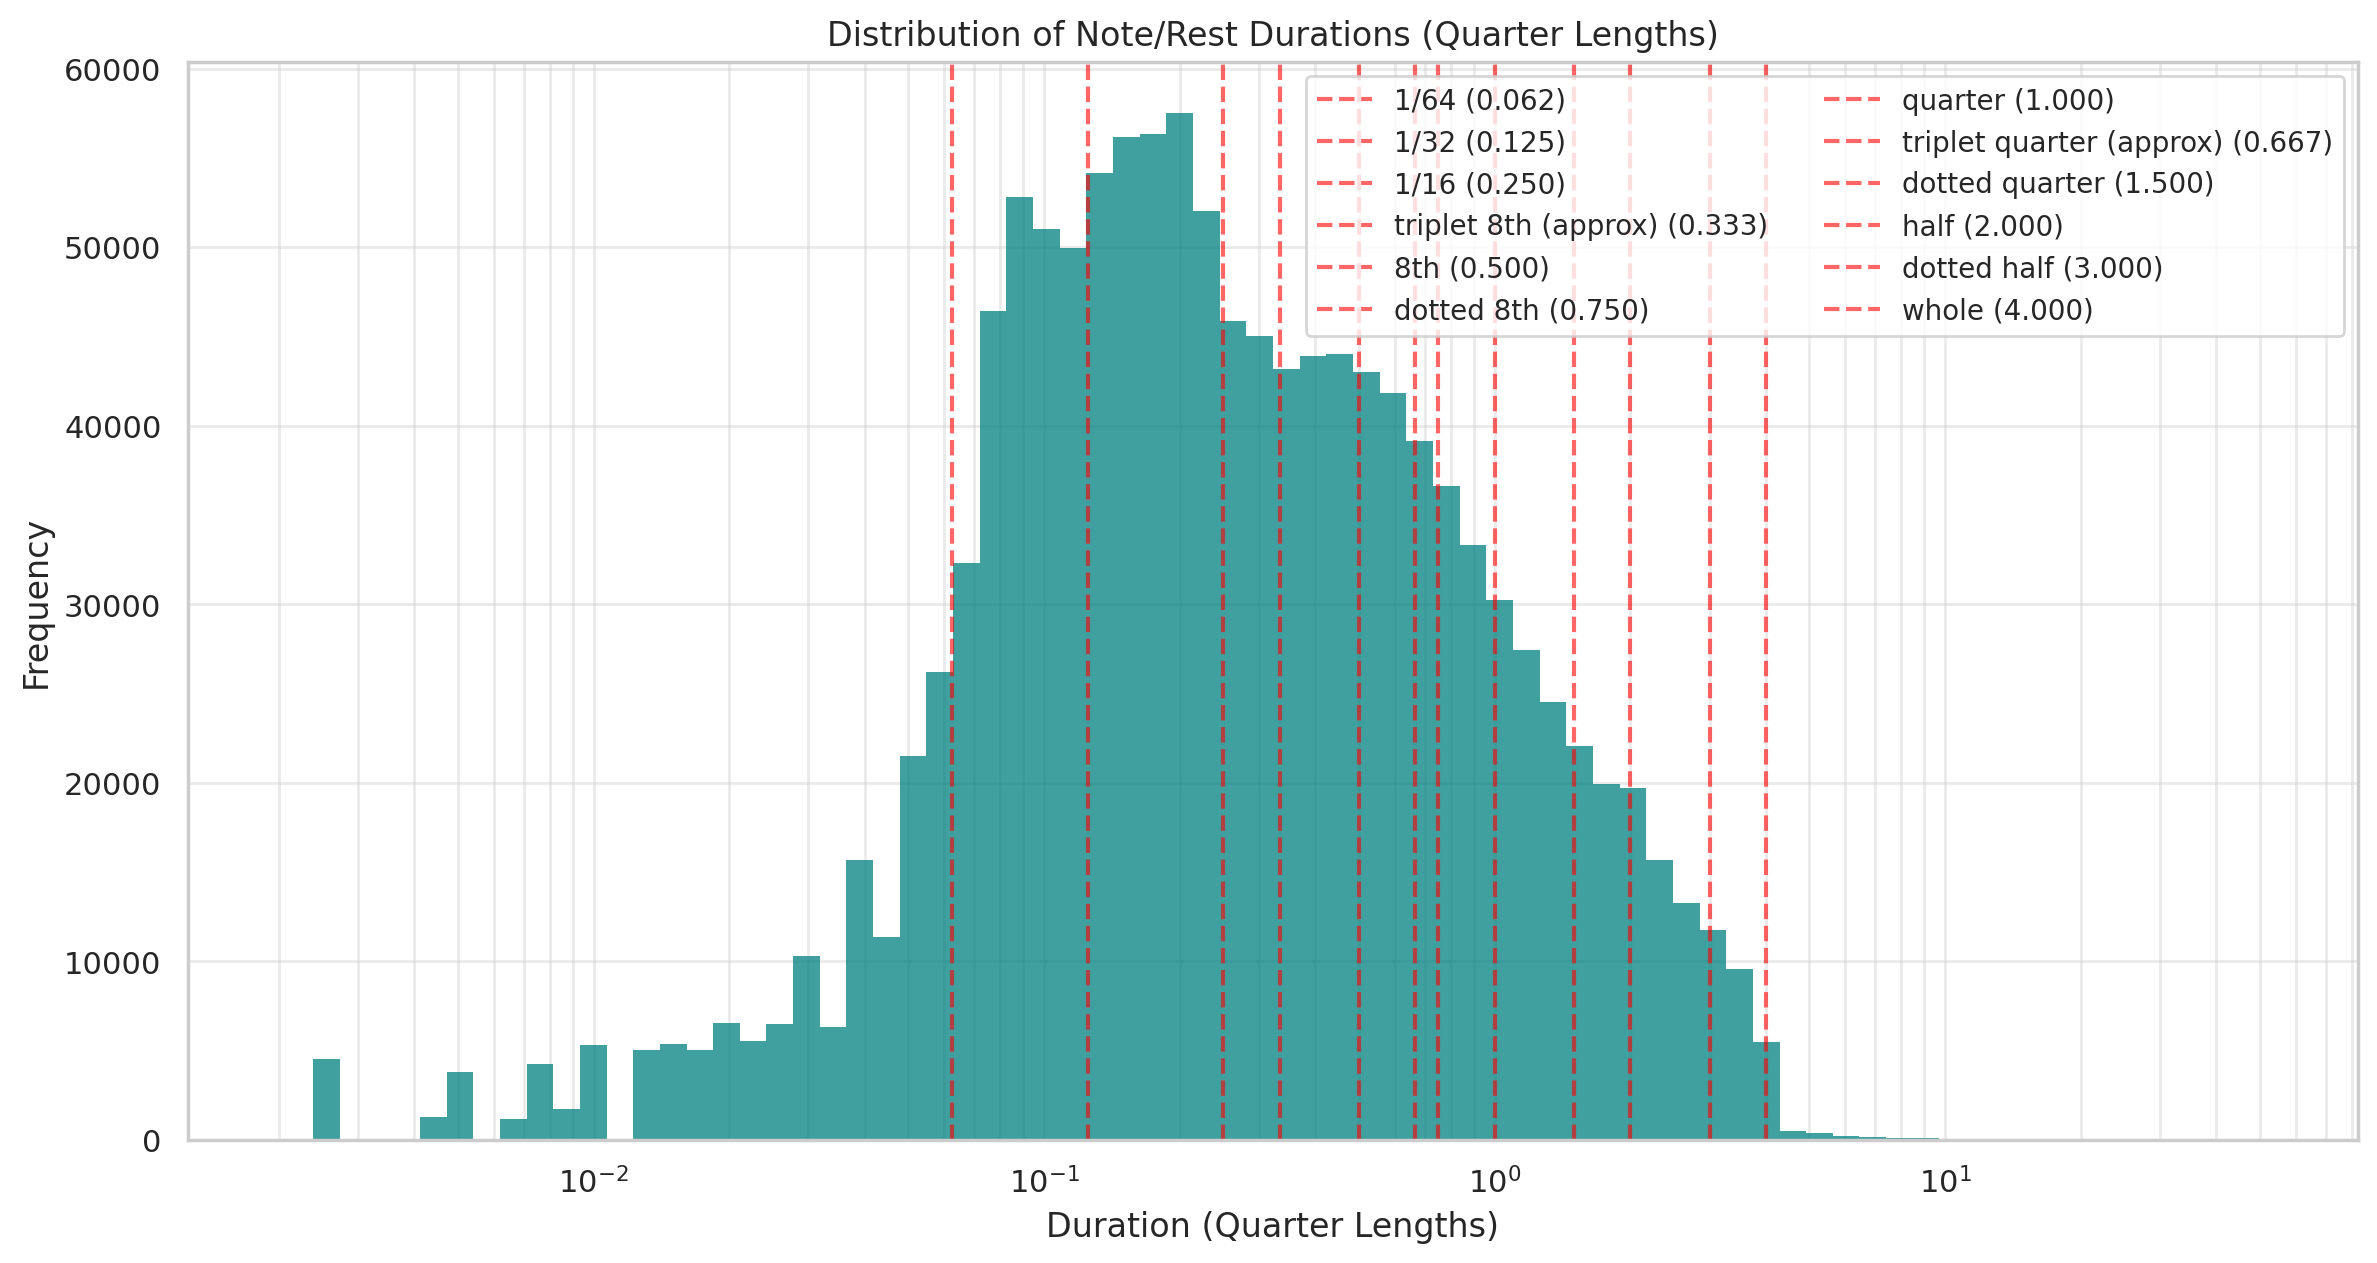

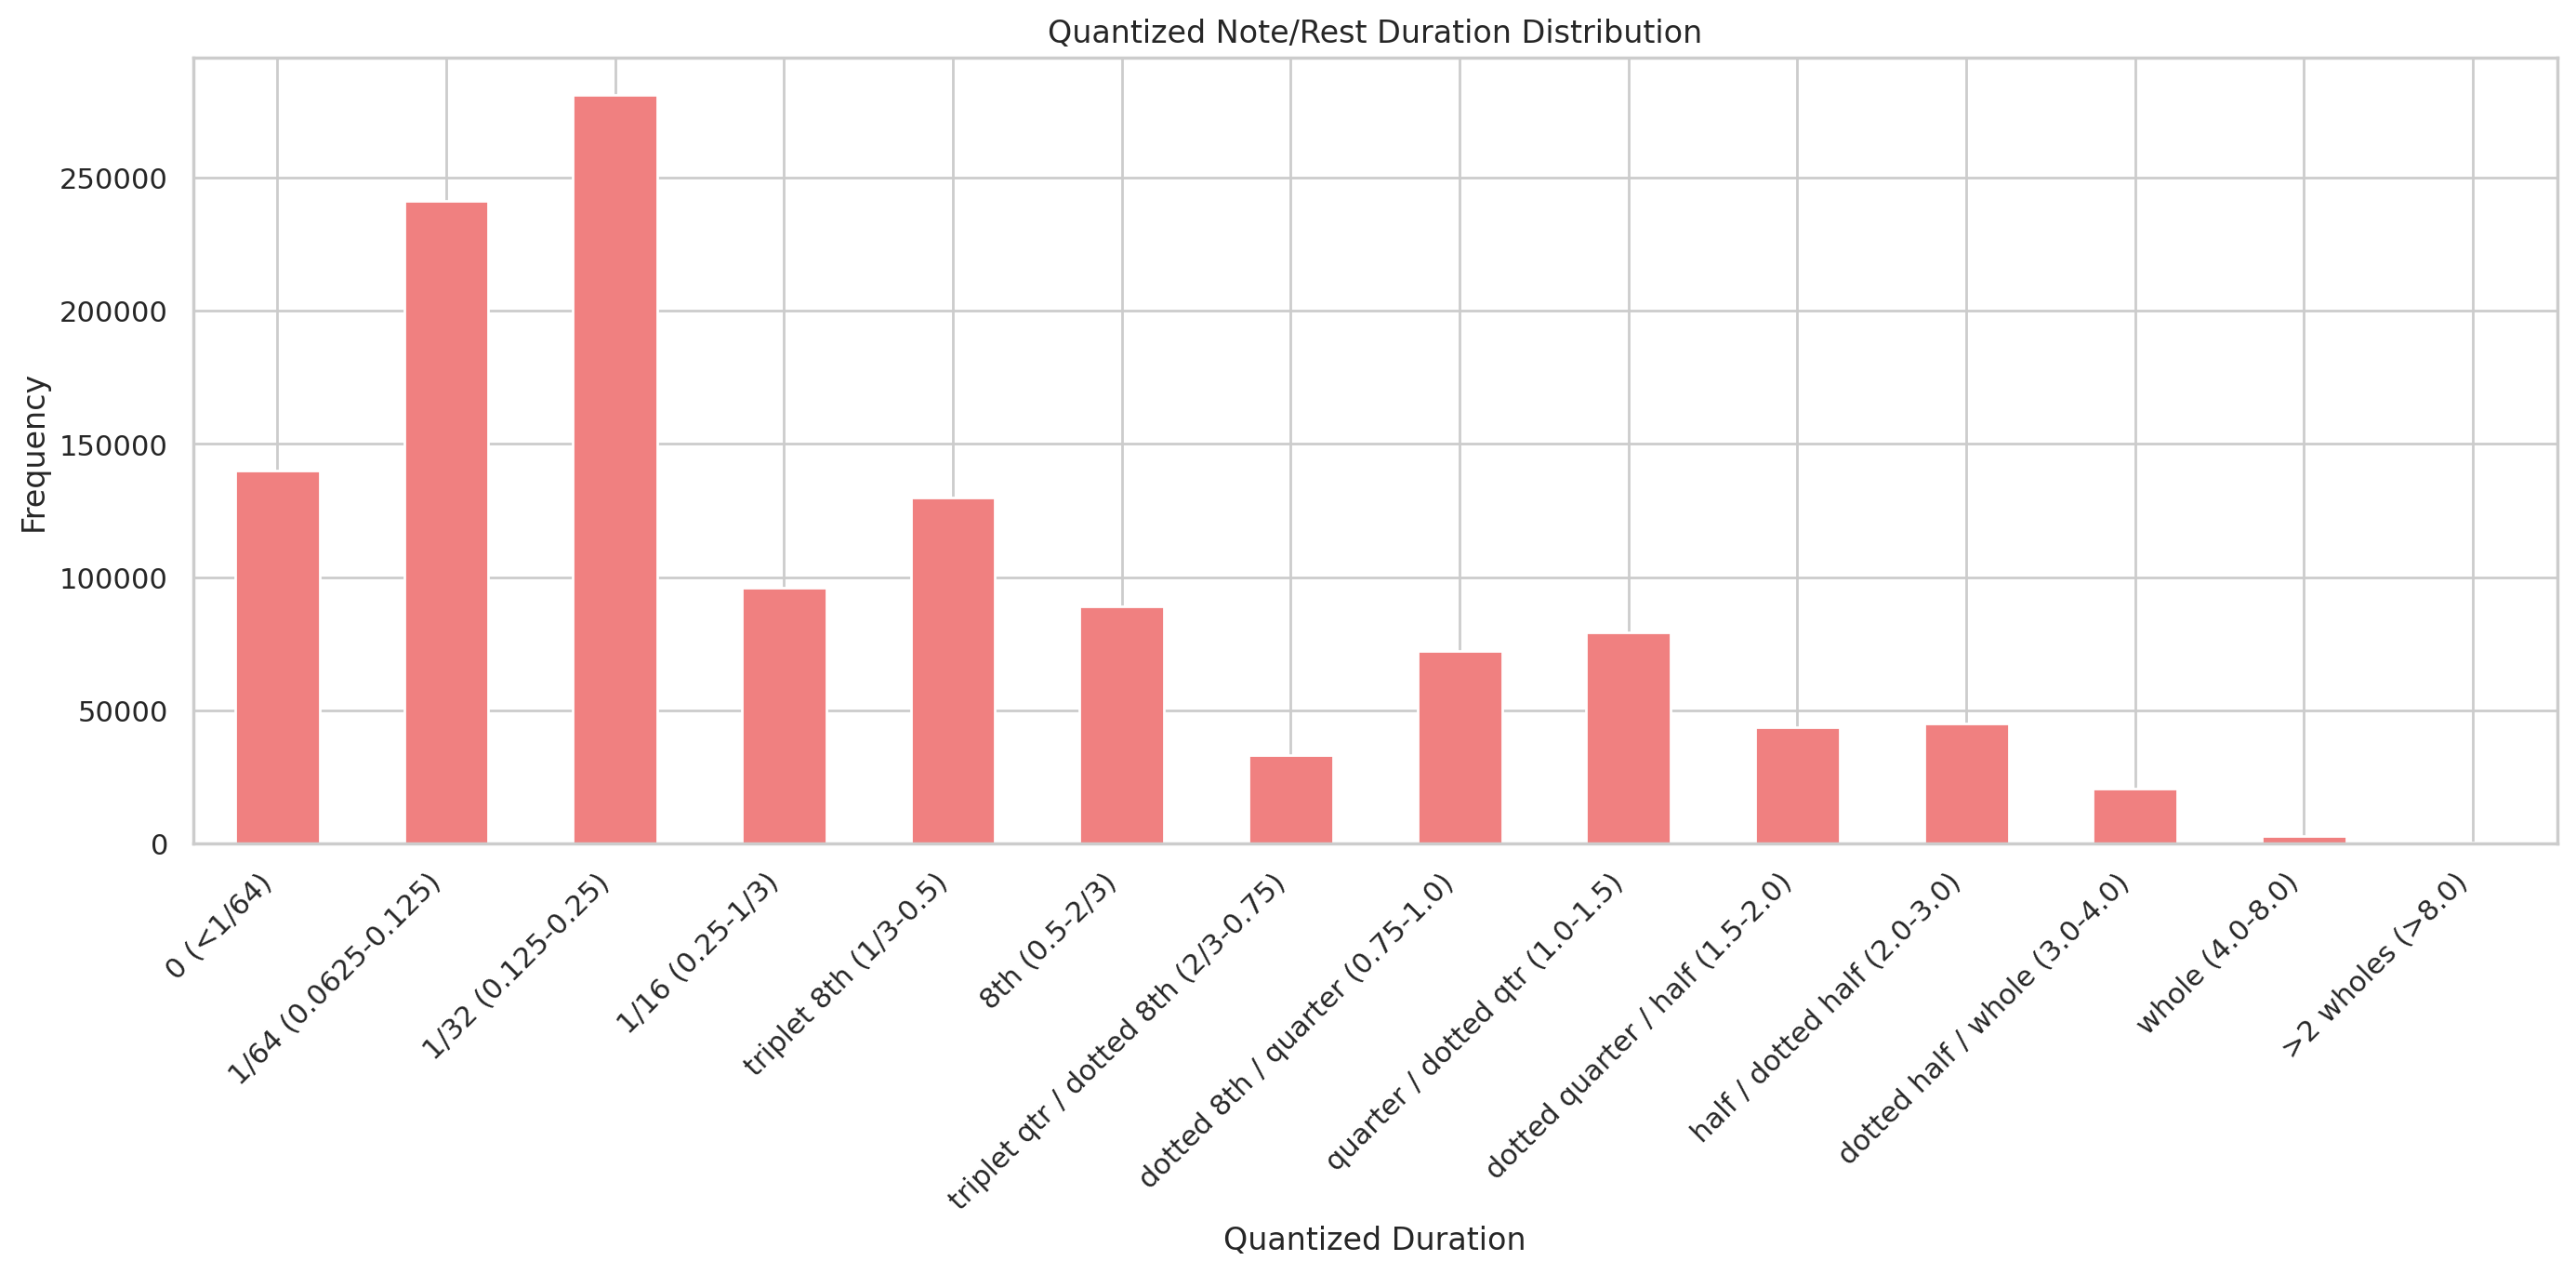


Top 10 Most Frequent Quantized Durations:
    Quantized Duration Interval  Count  Percentage
              1/32 (0.125-0.25) 280907   22.032561
            1/64 (0.0625-0.125) 241135   18.913098
                      0 (<1/64) 140140   10.991692
          triplet 8th (1/3-0.5) 129923   10.190335
                1/16 (0.25-1/3)  96126    7.539513
                  8th (0.5-2/3)  89083    6.987105
 quarter / dotted qtr (1.0-1.5)  79433    6.230220
dotted 8th / quarter (0.75-1.0)  72364    5.675773
   half / dotted half (2.0-3.0)  45143    3.540730
dotted quarter / half (1.5-2.0)  43544    3.415315


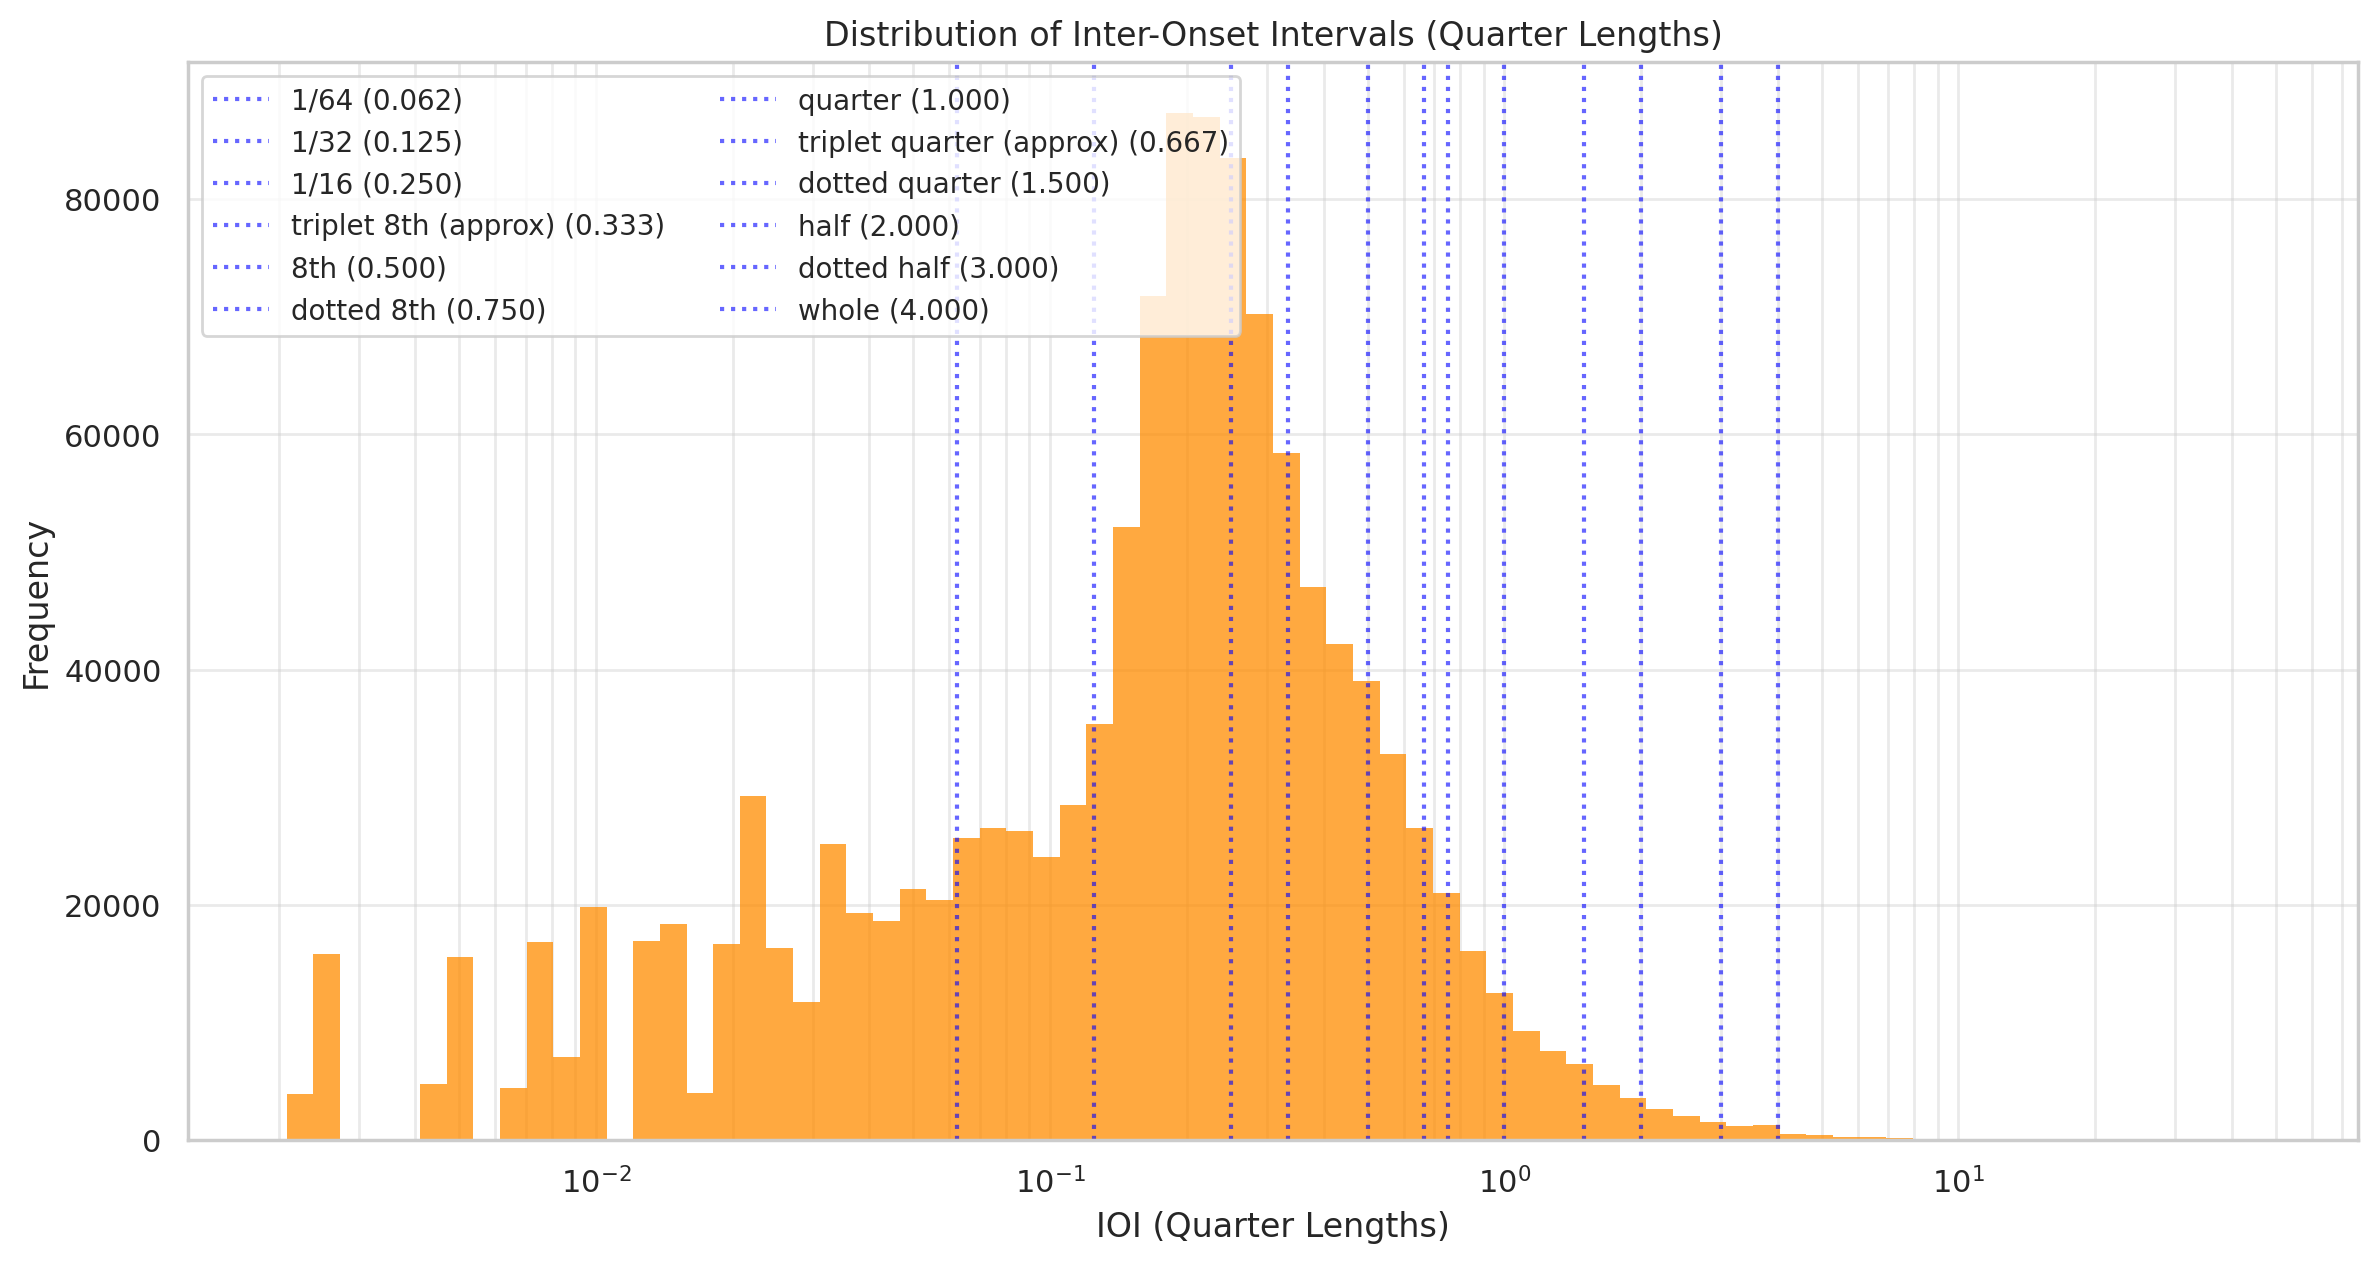


Per-Piece Rhythmic Feature Summary:
       avg_duration_ql  median_duration_ql  std_duration_ql  num_rhythmic_elements   avg_ioi_ql  median_ioi_ql   std_ioi_ql     num_iois
count      1276.000000         1276.000000      1276.000000            1276.000000  1276.000000    1276.000000  1276.000000  1276.000000
mean          0.481634            0.263073         0.644065            3768.661442     0.277671       0.205581     0.389489  1765.568182
std           0.184541            0.144513         0.176321            1003.062821     0.096284       0.065613     0.218901   493.972251
min           0.155767            0.088542         0.327193             332.000000     0.126857       0.062500     0.071279   146.000000
25%           0.345181            0.164583         0.522466            3115.750000     0.218113       0.164583     0.248987  1431.500000
50%           0.454159            0.218750         0.621852            3749.000000     0.259978       0.192187     0.343015  1751.000000
75% 

In [24]:
# Ensure required columns are present and non-empty
if not combined_df.empty and 'durations_ql_sample' in combined_df.columns and 'iois_ql_sample' in combined_df.columns:

    # Flatten and filter all durations and IOIs
    all_durations_ql = [
        d for row in combined_df['durations_ql_sample']
        if isinstance(row, list) for d in row if d > 1e-6
    ]
    all_iois_ql = [
        i for row in combined_df['iois_ql_sample']
        if isinstance(row, list) for i in row if i > 1e-6
    ]

    # Reference durations for plotting
    common_qls = {
        '1/64': 0.0625, '1/32': 0.125, '1/16': 0.25, 'triplet 8th (approx)': 1/3,
        '8th': 0.5, 'dotted 8th': 0.75, 'quarter': 1.0,
        'triplet quarter (approx)': 2/3, 'dotted quarter': 1.5,
        'half': 2.0, 'dotted half': 3.0, 'whole': 4.0
    }

    # === DURATIONS HISTOGRAM (log scale) ===
    if all_durations_ql:
        plt.figure(figsize=(14, 7))
        min_dur, max_dur = np.min(all_durations_ql), np.max(all_durations_ql)
        log_bins = np.logspace(np.log10(min_dur), np.log10(max_dur), 75)
        sns.histplot(all_durations_ql, bins=log_bins, color='teal')
        plt.xscale('log')
        plt.title('Distribution of Note/Rest Durations (Quarter Lengths)')
        plt.xlabel('Duration (Quarter Lengths)')
        plt.ylabel('Frequency')
        for name, val in common_qls.items():
            if min_dur < val < max_dur:
                plt.axvline(val, color='red', linestyle='--', alpha=0.6, label=f'{name} ({val:.3f})')
        plt.legend(fontsize='small', ncol=2)
        plt.grid(True, which="both", ls="-", alpha=0.4)
        plt.show()

        # === QUANTIZED DURATION BINS ===
        duration_bins = [0, 0.0625, 0.125, 0.25, 1/3, 0.5, 2/3, 0.75, 1.0, 1.5, 2.0, 3.0, 4.0, 8.0, float('inf')]
        duration_labels = [
            '0 (<1/64)', '1/64 (0.0625-0.125)', '1/32 (0.125-0.25)', '1/16 (0.25-1/3)',
            'triplet 8th (1/3-0.5)', '8th (0.5-2/3)', 'triplet qtr / dotted 8th (2/3-0.75)',
            'dotted 8th / quarter (0.75-1.0)', 'quarter / dotted qtr (1.0-1.5)',
            'dotted quarter / half (1.5-2.0)', 'half / dotted half (2.0-3.0)',
            'dotted half / whole (3.0-4.0)', 'whole (4.0-8.0)', '>2 wholes (>8.0)'
        ]
        quantized_durs = pd.cut(all_durations_ql, bins=duration_bins, labels=duration_labels, right=False)
        plt.figure(figsize=(14, 7))
        quantized_durs.value_counts().sort_index().plot(kind='bar', color='lightcoral')
        plt.title('Quantized Note/Rest Duration Distribution')
        plt.xlabel('Quantized Duration')
        plt.ylabel('Frequency')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

        # === TOP QUANTIZED DURATION STATS ===
        quantized_dur_table = quantized_durs.value_counts().nlargest(10).reset_index()
        quantized_dur_table.columns = ['Quantized Duration Interval', 'Count']
        quantized_dur_table['Percentage'] = (quantized_dur_table['Count'] / len(quantized_durs)) * 100
        print("\nTop 10 Most Frequent Quantized Durations:")
        print(quantized_dur_table.to_string(index=False))
    else:
        print("No valid duration data.")

    # === IOI HISTOGRAM (log scale) ===
    if all_iois_ql:
        plt.figure(figsize=(14, 7))
        min_ioi, max_ioi = np.min(all_iois_ql), np.max(all_iois_ql)
        log_bins_ioi = np.logspace(np.log10(min_ioi), np.log10(max_ioi), 75)
        sns.histplot(all_iois_ql, bins=log_bins_ioi, color='darkorange')
        plt.xscale('log')
        plt.title('Distribution of Inter-Onset Intervals (Quarter Lengths)')
        plt.xlabel('IOI (Quarter Lengths)')
        plt.ylabel('Frequency')
        for name, val in common_qls.items():
            if min_ioi < val < max_ioi:
                plt.axvline(val, color='blue', linestyle=':', alpha=0.6, label=f'{name} ({val:.3f})')
        plt.legend(fontsize='small', ncol=2)
        plt.grid(True, which="both", ls="-", alpha=0.4)
        plt.show()
    else:
        print("No valid IOI data.")

    # === PER-PIECE RHYTHMIC SUMMARY ===
    rhythm_summary_cols = [
        'avg_duration_ql', 'median_duration_ql', 'std_duration_ql', 'num_rhythmic_elements',
        'avg_ioi_ql', 'median_ioi_ql', 'std_ioi_ql', 'num_iois'
    ]
    summary_cols = [col for col in rhythm_summary_cols if col in combined_df.columns]
    if summary_cols and not combined_df[summary_cols].dropna().empty:
        print("\nPer-Piece Rhythmic Feature Summary:")
        print(combined_df[summary_cols].describe())
    else:
        print("No rhythmic summary stats available.")
else:
    print("Required rhythmic columns missing in combined_df.")


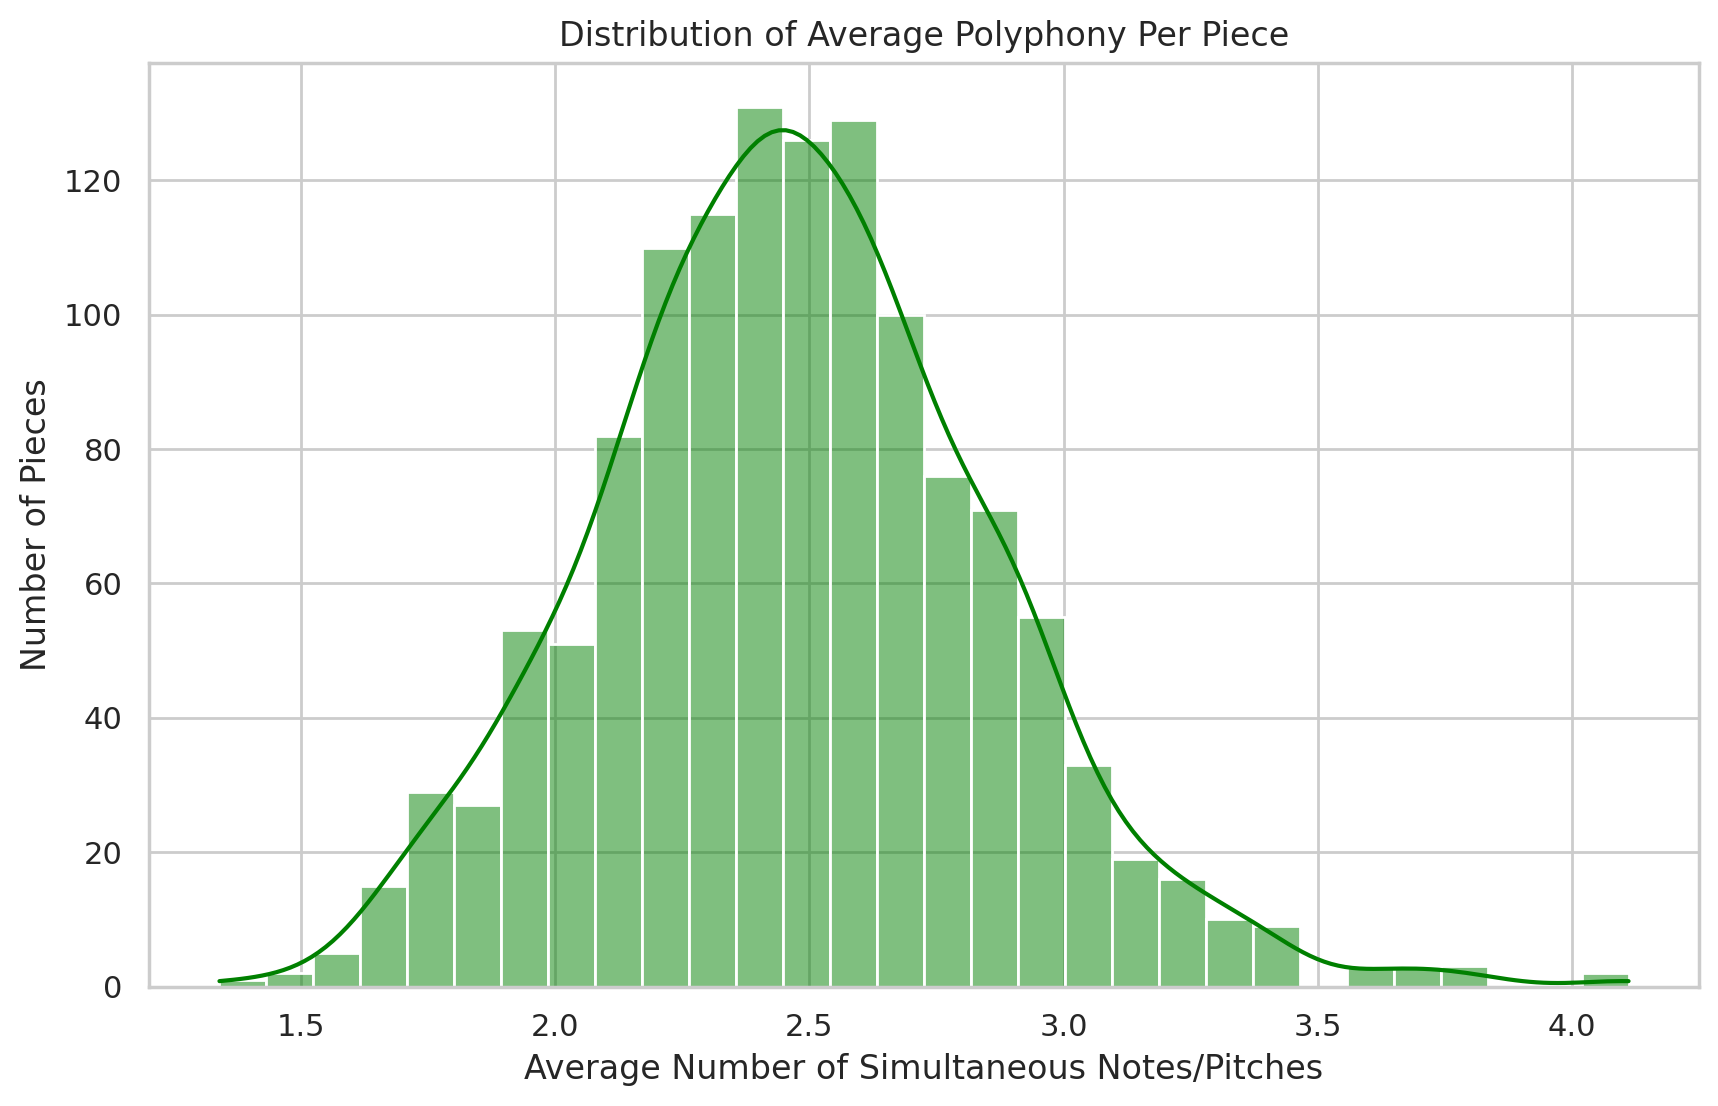


Summary statistics for average polyphony:
count    1276.000000
mean        2.471446
std         0.383359
min         1.340520
25%         2.218269
50%         2.454759
75%         2.710557
max         4.110858
Name: avg_polyphony, dtype: float64


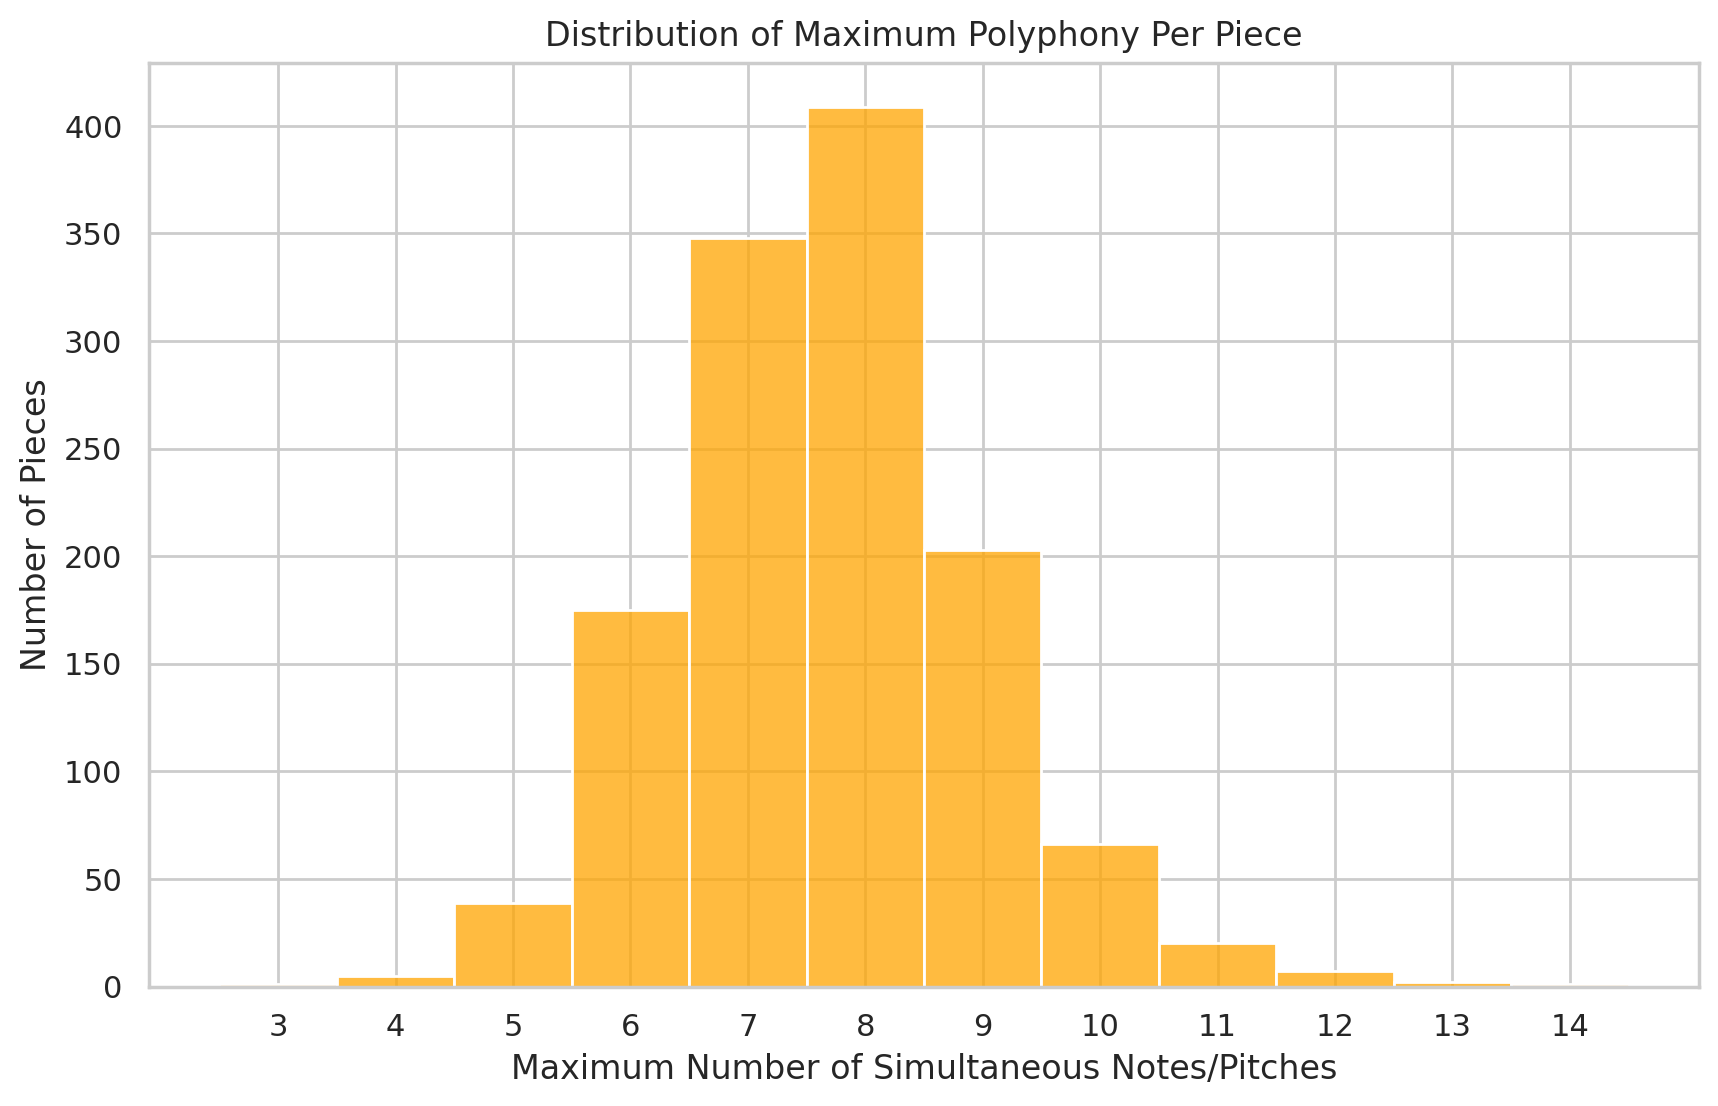


Summary statistics for maximum polyphony:
count    1276.000000
mean        7.685737
std         1.320422
min         3.000000
25%         7.000000
50%         8.000000
75%         8.000000
max        14.000000
Name: max_polyphony, dtype: float64
No aggregated polyphony level data to plot.


In [26]:
if not combined_df.empty and 'avg_polyphony' in combined_df.columns and 'max_polyphony' in combined_df.columns:
    valid_avg_polyphony = combined_df['avg_polyphony'].dropna()
    valid_avg_polyphony = valid_avg_polyphony[valid_avg_polyphony >= 0]

    valid_max_polyphony = combined_df['max_polyphony'].dropna()
    valid_max_polyphony = valid_max_polyphony[valid_max_polyphony >= 0]

    if not valid_avg_polyphony.empty:
        plt.figure(figsize=(10, 6))
        sns.histplot(valid_avg_polyphony, bins=30, kde=True, color="green")
        plt.title('Distribution of Average Polyphony Per Piece')
        plt.xlabel('Average Number of Simultaneous Notes/Pitches')
        plt.ylabel('Number of Pieces')
        plt.show()
        print("\nSummary statistics for average polyphony:")
        print(valid_avg_polyphony.describe())

    if not valid_max_polyphony.empty:
        plt.figure(figsize=(10, 6))
        sns.histplot(valid_max_polyphony, bins=max(1, int(valid_max_polyphony.max()) - int(valid_max_polyphony.min())), kde=False, color="orange", discrete=True if valid_max_polyphony.nunique()<30 else False)
        plt.title('Distribution of Maximum Polyphony Per Piece')
        plt.xlabel('Maximum Number of Simultaneous Notes/Pitches')
        plt.ylabel('Number of Pieces')
        if not valid_max_polyphony.empty:
            plt.xticks(np.arange(int(valid_max_polyphony.min()), int(valid_max_polyphony.max())+1, step=max(1, int(valid_max_polyphony.max())//10)))
        plt.show()
        print("\nSummary statistics for maximum polyphony:")
        print(valid_max_polyphony.describe())
    
    all_polyphony_levels = []
    if 'polyphony_levels_sample' in combined_df.columns:
        for poly_list in combined_df['polyphony_levels_sample'].dropna():
            if isinstance(poly_list, list):
                all_polyphony_levels.extend(poly_list)
    
    all_polyphony_levels = [p for p in all_polyphony_levels if p > 0]

    if all_polyphony_levels:
        plt.figure(figsize=(12, 7))
        poly_counts = pd.Series(all_polyphony_levels).value_counts().sort_index()
        poly_counts_to_plot = poly_counts[poly_counts.index <= 12]
        
        sns.barplot(x=poly_counts_to_plot.index, y=poly_counts_to_plot.values, color="cyan")
        plt.title('Overall Distribution of Polyphony Levels (at onsets, up to 12 voices)')
        plt.xlabel('Number of Simultaneous Notes/Pitches')
        plt.ylabel('Frequency of Onsets')
        plt.show()
    else:
        print("No aggregated polyphony level data to plot.")
else:
    print("Polyphony features ('avg_polyphony', 'max_polyphony') not available in combined_df for analysis.")

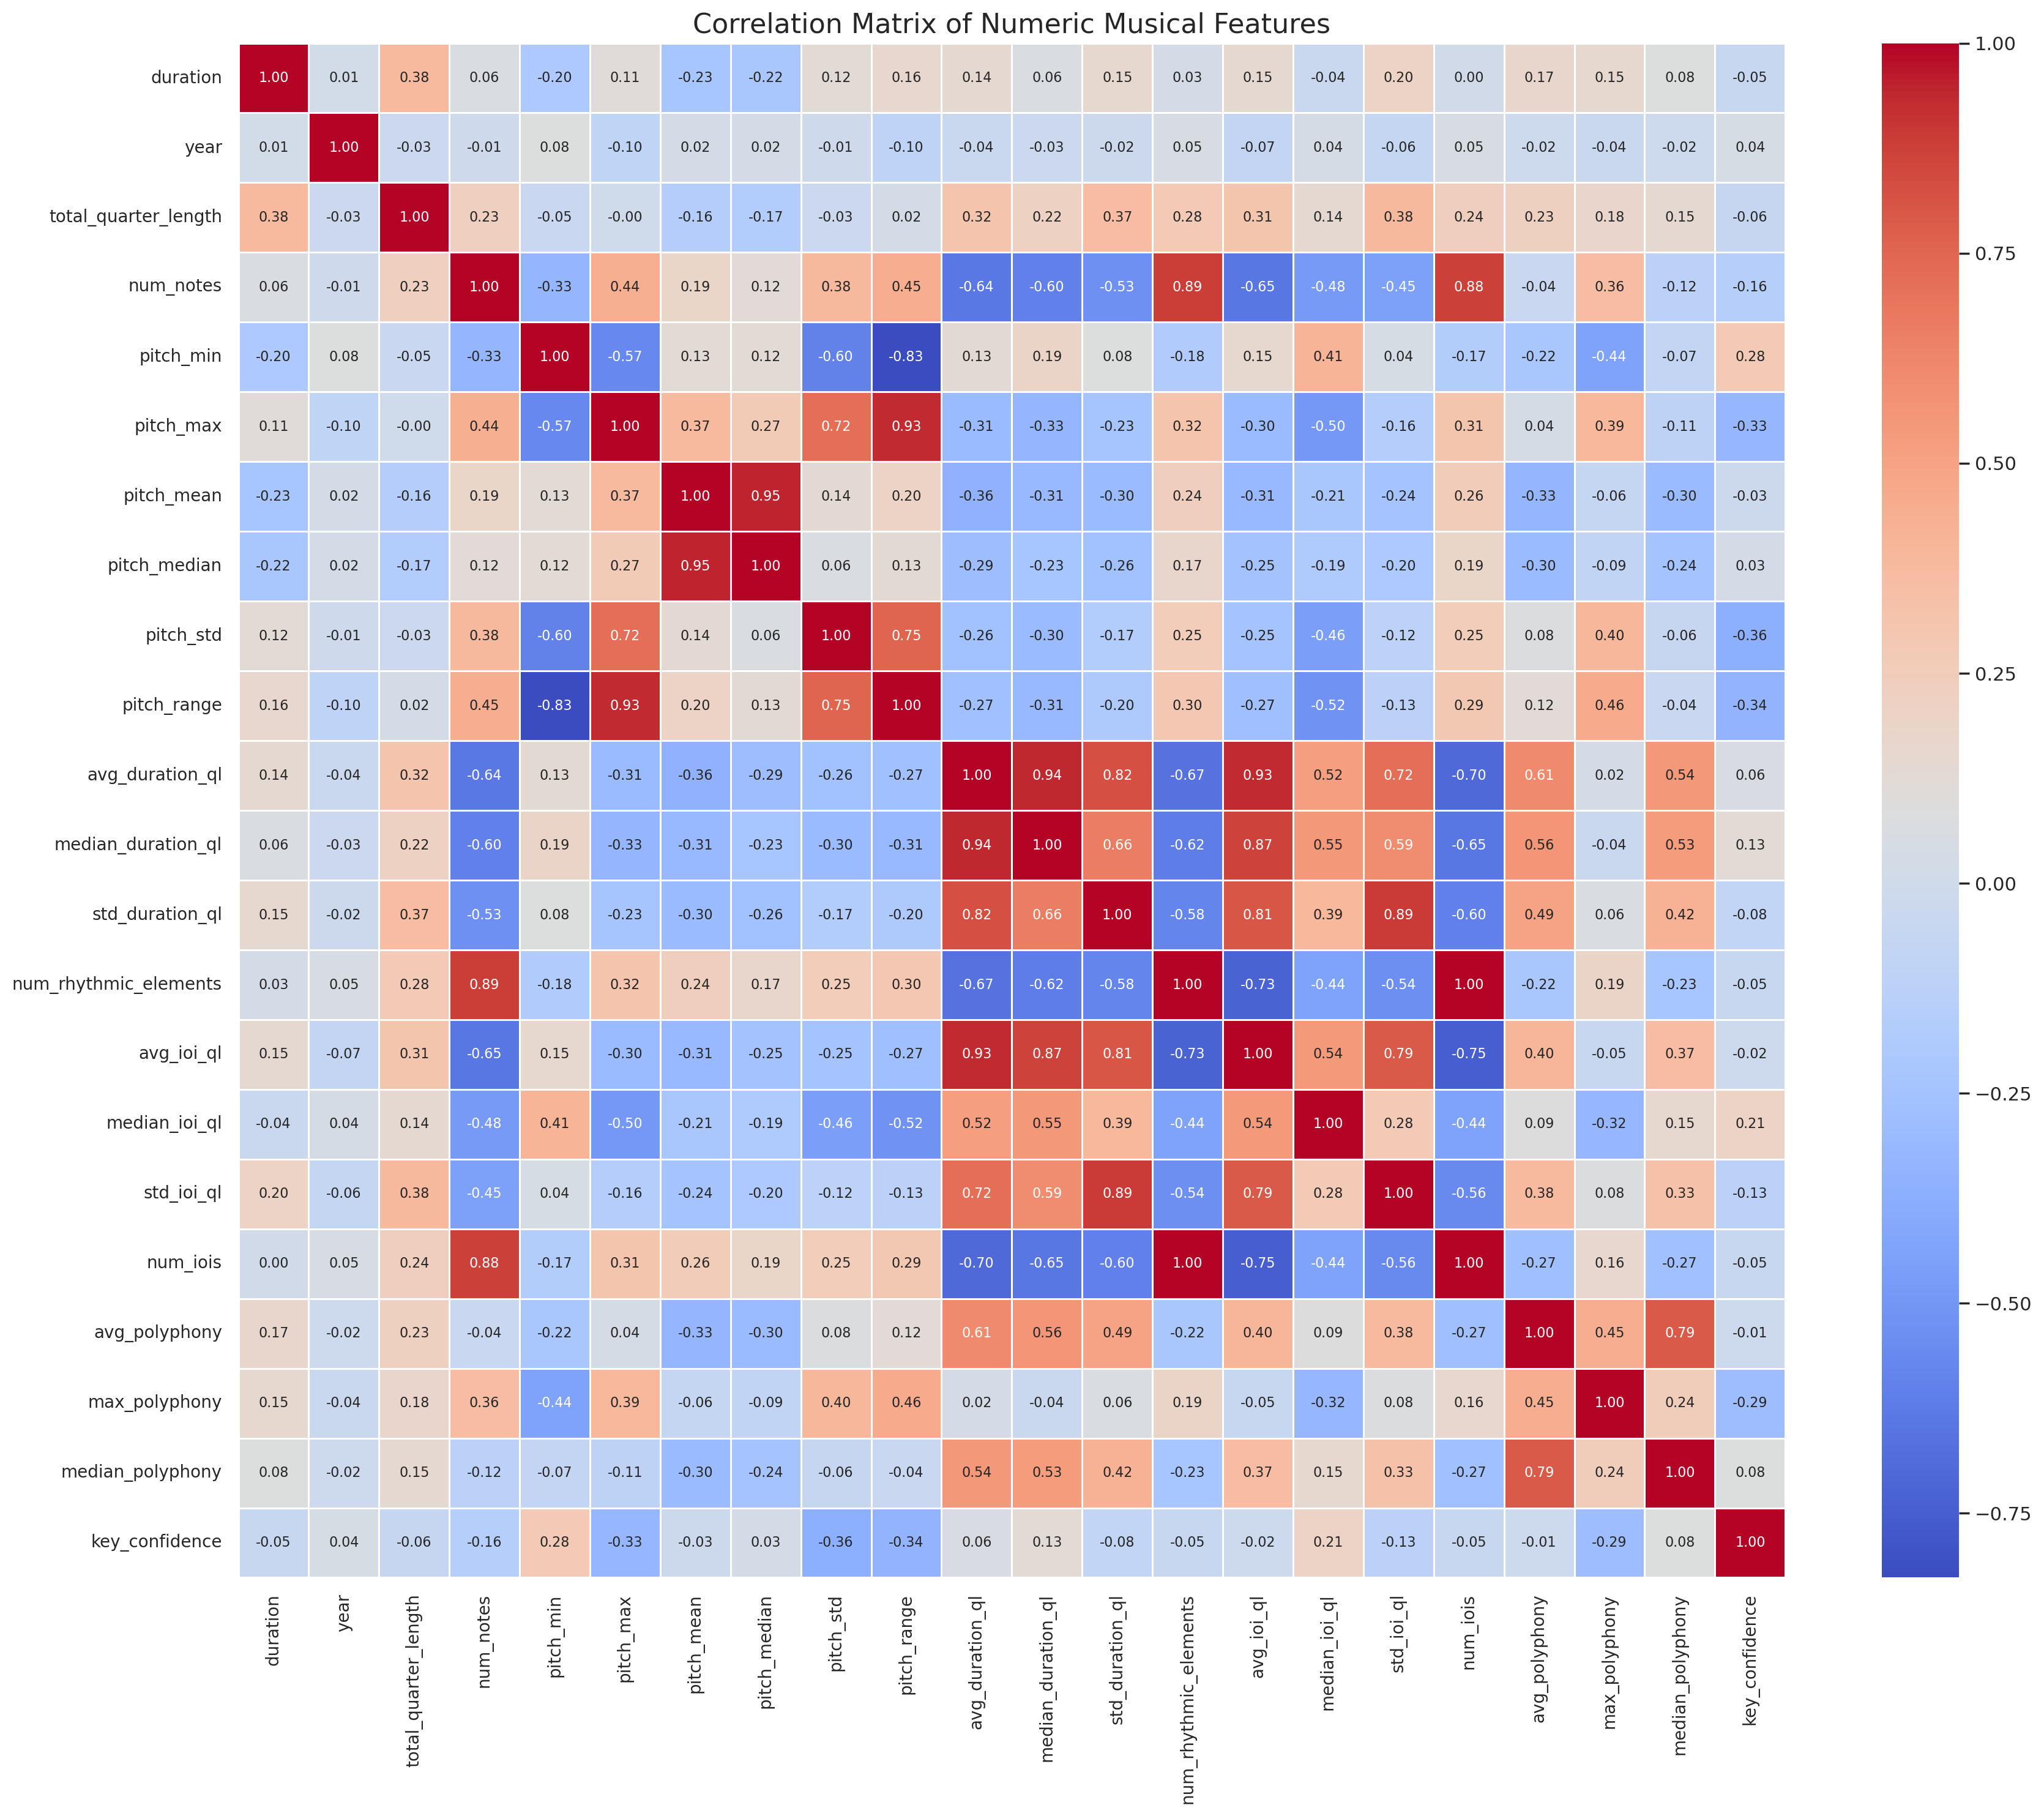

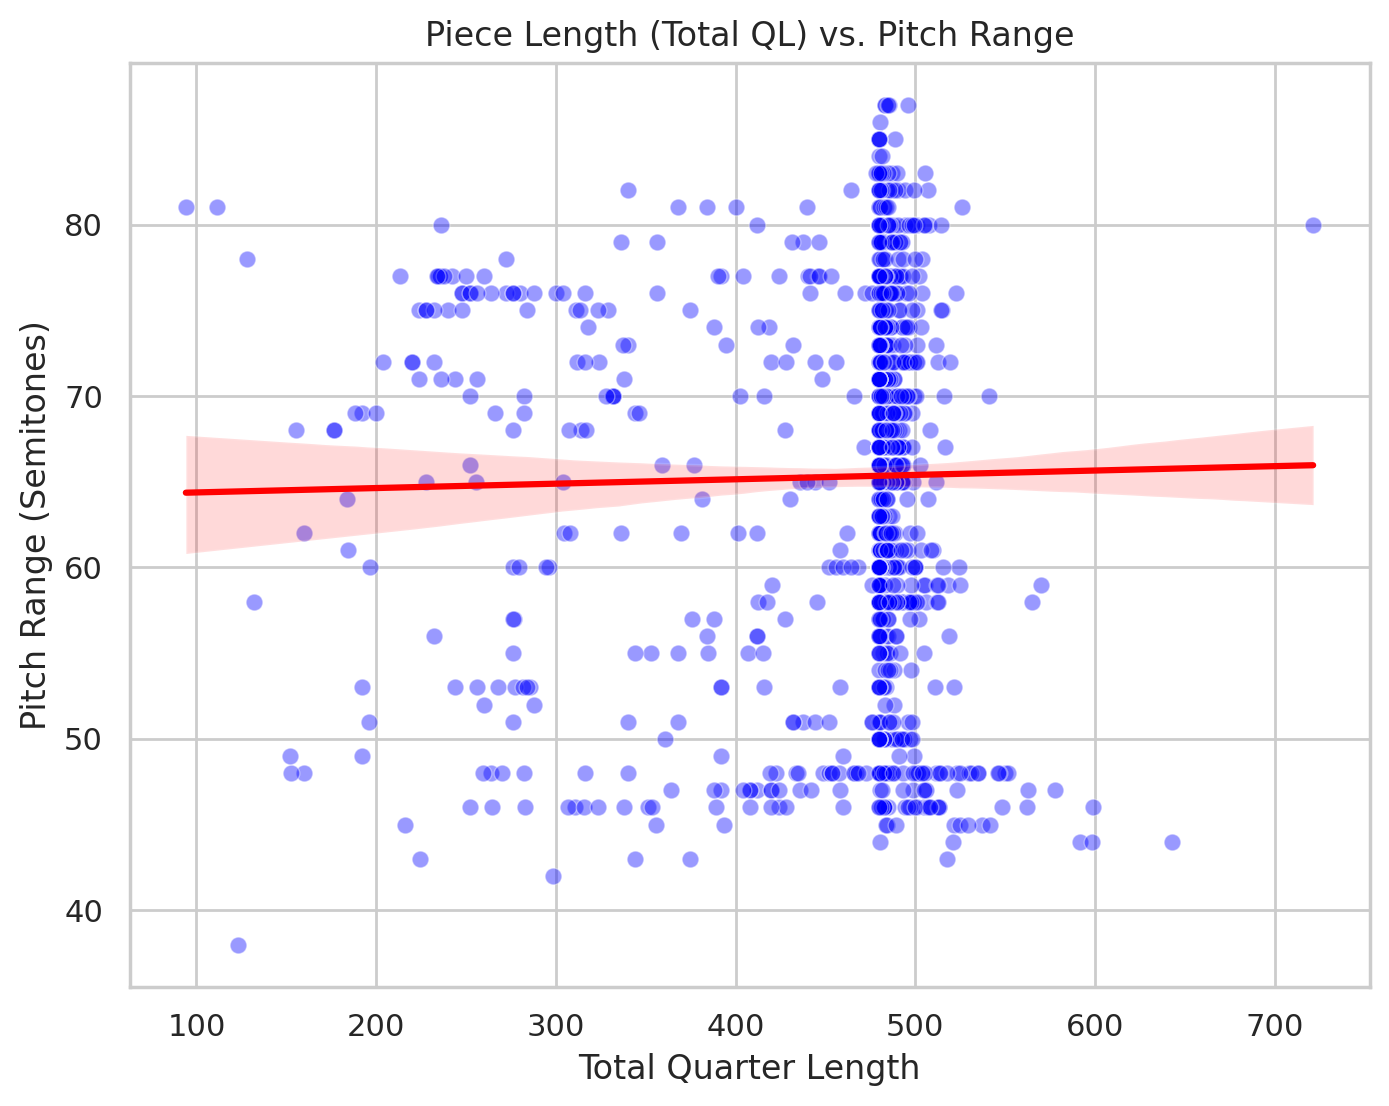

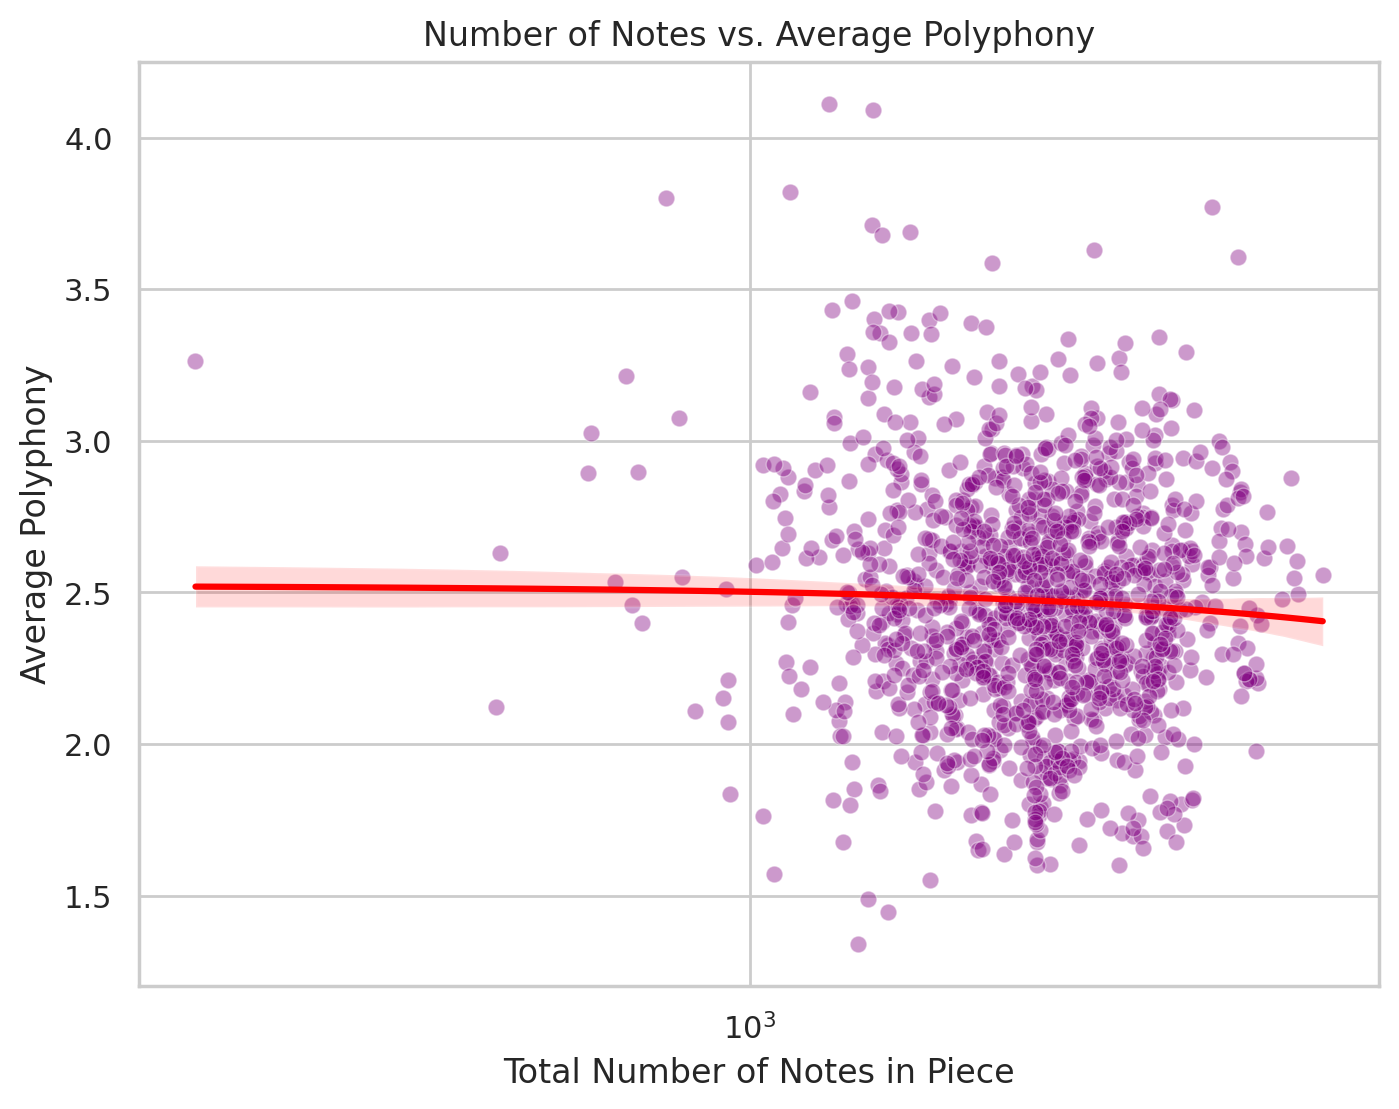

In [28]:
if not combined_df.empty:
    numeric_features_for_corr = [
        'duration', 
        'year', 
        'total_quarter_length', 
        'num_notes',
        'pitch_min', 'pitch_max', 'pitch_mean', 'pitch_median', 'pitch_std', 'pitch_range',
        'avg_duration_ql', 'median_duration_ql', 'std_duration_ql', 'num_rhythmic_elements',
        'avg_ioi_ql', 'median_ioi_ql', 'std_ioi_ql', 'num_iois',
        'avg_polyphony', 'max_polyphony', 'median_polyphony',
        'key_confidence'
    ]
    
    existing_numeric_cols_for_corr = [col for col in numeric_features_for_corr if col in combined_df.columns and pd.api.types.is_numeric_dtype(combined_df[col])]
    
    if not existing_numeric_cols_for_corr or len(existing_numeric_cols_for_corr) < 2:
        print("Not enough numeric features available for correlation analysis.")
    else:
        corr_df_subset = combined_df[existing_numeric_cols_for_corr].copy()
        corr_df_subset.dropna(inplace=True)

        if not corr_df_subset.empty and len(corr_df_subset.columns) > 1 and len(corr_df_subset) > 1:
            correlation_matrix = corr_df_subset.corr()
            
            plt.figure(figsize=(18, 15))
            sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, annot_kws={"size": 8})
            plt.title('Correlation Matrix of Numeric Musical Features', fontsize=16)
            plt.xticks(fontsize=10)
            plt.yticks(fontsize=10)
            plt.tight_layout()
            plt.show()

            if 'total_quarter_length' in corr_df_subset.columns and 'pitch_range' in corr_df_subset.columns:
                plt.figure(figsize=(8, 6))
                sns.scatterplot(data=corr_df_subset, x='total_quarter_length', y='pitch_range', alpha=0.4, color='blue')
                sns.regplot(data=corr_df_subset, x='total_quarter_length', y='pitch_range', scatter=False, color='red')
                plt.title('Piece Length (Total QL) vs. Pitch Range')
                plt.xlabel('Total Quarter Length')
                plt.ylabel('Pitch Range (Semitones)')
                plt.grid(True)
                plt.show()

            if 'initial_tempo_bpm' in corr_df_subset.columns and 'avg_ioi_ql' in corr_df_subset.columns:
                plt.figure(figsize=(8, 6))
                sns.scatterplot(data=corr_df_subset, x='initial_tempo_bpm', y='avg_ioi_ql', alpha=0.4, color='green')
                sns.regplot(data=corr_df_subset, x='initial_tempo_bpm', y='avg_ioi_ql', scatter=False, color='red')
                plt.title('Initial Tempo (BPM) vs. Average Inter-Onset Interval (QL)')
                plt.xlabel('Initial Tempo (BPM)')
                plt.ylabel('Average IOI (Quarter Lengths)')
                plt.grid(True)
                plt.show()
                
            if 'avg_polyphony' in corr_df_subset.columns and 'num_notes' in corr_df_subset.columns:
                plt.figure(figsize=(8, 6))
                sns.scatterplot(data=corr_df_subset, x='num_notes', y='avg_polyphony', alpha=0.4, color='purple')
                sns.regplot(data=corr_df_subset, x='num_notes', y='avg_polyphony', scatter=False, color='red')
                plt.title('Number of Notes vs. Average Polyphony')
                plt.xlabel('Total Number of Notes in Piece')
                plt.ylabel('Average Polyphony')
                plt.xscale('log')
                plt.grid(True)
                plt.show()

        else:
            print("Not enough data or numeric columns for correlation analysis after cleaning NaNs.")
else:
    print("Combined DataFrame is empty. Cannot perform correlation analysis.")

# Task 1 - Symbolic Music Generation Unconditioned

## Task Outline and Implementation

Our goal here is to generate a MIDI file of a 3 Minute duration based on the document corpus we have. The documents being the unprocessed MIDI files provided by the Maestro Dataset. 

As we're doing unconditioned generation, this means learning the underlying probability distribution of the dataset. $p(x)$, where $x$ is a sequence of notes. 

As a BASELINE: we'll be using a 3rd Order Markov Chain to generate the MIDI file. 

This is the simplest model that we can use to generate music, and it'll be a good baseline to compare our more complex models against. A Markov Chain works via the following formula:

$$p(x) = p(x_1) \prod_{i=2}^{n} p(x_i | x_{i-1}, x_{i-2}, x_{i-3})$$

Where $x_1, x_2, x_3$ are the initial states of the Markov Chain. 

For our implementation, we'll be using the `music21` library as well as an LSTM model to generate the MIDI file. 

### LSTM

An LSTM (Long Short-Term Memory) model is a type of recurrent neural network (RNN) that can learn and remember patterns in data over time. It is particularly effective for tasks involving sequences, such as music generation.

The LSTM model has a unique architecture that allows it to selectively remember or forget information over time. It does this through a series of gates:

1. **Input Gate**: Controls how much of the new input should be added to the cell state.

2. **Forget Gate**: Determines how much of the previous cell state should be forgotten.

3. **Output Gate**: Controls the output of the cell state.

4. **Cell State**: The core memory of the LSTM, which stores the information over time.

That being said, this logic is abstracted away from us, and we can use the `torch` library to implement our own LSTM model.
The metric that we will be using is `perplexity`, coupled with active listening of generated products to see if they sound good.

### Perplexity

Perplexity is a measure of how well a probability model predicts a sample. It is defined as the reciprocal of the probability of the sample.

$$PPL(x) = \frac{1}{p(x)}$$

Where $p(x)$ is the probability of the sample.



In [45]:
import numpy as np
import pandas as pd
from pathlib import Path
import music21
from music21 import converter, note, chord, stream, instrument, tempo
from collections import defaultdict, Counter
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
import multiprocessing
# tqdm.auto
from tqdm.auto import tqdm
import warnings

warnings.filterwarnings('ignore', category=UserWarning, module='music21')
warnings.filterwarnings('ignore', category=FutureWarning) # General FutureWarnings
# print torch GPU available
print(torch.cuda.is_available())
# --- Configuration ---
DATA_DIR = Path('../data/')  # Adjust if your data is elsewhere
MAESTRO_METADATA_FILE = DATA_DIR / 'maestro-v3.0.0.csv'
MIDI_BASE_PATH = DATA_DIR # MIDI files are in subdirectories like data/2004/
CACHE_DIR = Path('../cache/')
CACHE_DIR.mkdir(parents=True, exist_ok=True)
TRAIN_CACHE_FILE = CACHE_DIR / 'train_cache.npz'
VAL_CACHE_FILE = CACHE_DIR / 'val_cache.npz'
TEST_CACHE_FILE = CACHE_DIR / 'test_cache.npz'

# Model and Generation Parameters
MARKOV_ORDER = 3  # Order of the Markov chain
LSTM_SEQUENCE_LENGTH = 50
LSTM_EMBEDDING_DIM = 128
LSTM_UNITS = 256
LSTM_EPOCHS = 15 # Adjust based on dataset size and convergence
LSTM_BATCH_SIZE = 3072
GENERATION_LENGTH = 5000 # Number of events to generate
QUANTIZED_DURATIONS_QN = np.array([
    0.0625,  # 64th note
    0.125,   # 32nd note
    0.1666,  # Approx. 16th note triplet component (1/6)
    0.25,    # 16th note
    0.3333,  # Approx. 8th note triplet component (1/3)
    0.5,     # 8th note
    0.6666,  # Approx. Quarter note triplet component (2/3)
    0.75,    # Dotted 8th note
    1.0,     # Quarter note
    1.5,     # Dotted Quarter note
    2.0,     # Half note
    3.0,     # Dotted Half note
    4.0      # Whole note
])

def get_closest_quantized_duration(actual_ql: float) -> float:
    """Finds the closest duration from our predefined QUANTIZED_DURATIONS_QN list."""
    # Handle rests or very short notes gracefully, map them to the smallest positive duration
    if actual_ql <= 0:
        return QUANTIZED_DURATIONS_QN[0]
    idx = np.abs(QUANTIZED_DURATIONS_QN - actual_ql).argmin()
    return QUANTIZED_DURATIONS_QN[idx]

True


### Modeling MIDI Files as Sequences of Events

To train machine learning models on MIDI data, we need to convert complex symbolic music into structured, learnable sequences. Our pipeline transforms MIDI files into sequences of discrete tokens that encode pitch and rhythm. This enables us to treat music similarly to natural language in sequence modeling tasks.


### 1. **Loading Metadata**

We begin by loading the metadata from the MAESTRO dataset:

```python
df = pd.read_csv("maestro-v3.0.0.csv")
```

This metadata includes filenames, composers, durations, and other useful information. We augment it with the full path to each MIDI file:

```python
df['midi_filepath'] = df['midi_filename'].apply(lambda x: MIDI_BASE_PATH / x)
```

### 2. **Extracting Events from MIDI Files**

Each MIDI file is parsed using `music21`, and we extract notes, chords, and rests from a flattened score. Each musical element is converted into a string token encoding both pitch and duration.

* **Notes** are represented as:
  `"{midi_pitch}_{quantized_duration}"`
  e.g., `"60_0.5"` for Middle C with an eighth-note duration.

* **Chords** are represented as:
  `"{pitch1.pitch2.pitch3}_{quantized_duration}"`
  e.g., `"60.64.67_1.0"` for a C major triad with a quarter-note duration.

* **Rests** (if included) are represented as:
  `"Rest_{duration}"`

This results in a list of string tokens per MIDI file:

```python
["60_0.5", "64_0.5", "67_1.0", "Rest_0.25", "60.64.67_1.0", ...]
```

These token sequences become the model input.



### 3. **Vocabulary Creation**

All event sequences across the dataset are combined to build a vocabulary:

```python
event_to_int = {"60_0.5": 0, "64_0.5": 1, "67_1.0": 2, ...}
int_to_event = {0: "60_0.5", 1: "64_0.5", 2: "67_1.0", ...}
```

This mapping allows us to translate between human-readable events and integer IDs required for training sequence models (e.g., LSTMs, Transformers).

### 4. **Reconstructing MIDI from Event Sequences**

To evaluate generation or reconstruct training samples, we can decode a sequence of string events back into a MIDI file.

Each event string is parsed back into:

* A `note.Note`, `chord.Chord`, or `note.Rest`
* A `music21.duration.Duration` object

These are added sequentially to a `music21.stream.Stream`, along with a default instrument and tempo (e.g., Piano at 120 BPM). The stream is then saved as a new MIDI file.

```python
output_stream.write('midi', fp='output.mid')
```

### Summary

This pipeline effectively linearizes polyphonic symbolic music into a discrete token stream. By combining pitch and rhythmic duration into unified tokens, we retain essential musical information while making the data suitable for sequence-based deep learning models.


In [30]:
def load_maestro_metadata(file_path: Path) -> pd.DataFrame | None:
    """Loads MAESTRO metadata, adapted from the provided PDF."""
    if not file_path.exists():
        print(f"Metadata file not found: {file_path}")
        return None
    try:
        df = pd.read_csv(file_path)
        # Construct full MIDI path 
        df['midi_filepath'] = df['midi_filename'].apply(lambda x: MIDI_BASE_PATH / x)
        return df
    except Exception as e:
        print(f"Error loading metadata from {file_path}: {e}")
        return None

def extract_events_from_midi(midi_path: Path) -> list[str] | None:
    """Extracts notes/chords and their quantized durations as string events."""
    events = []
    try:
        score = converter.parse(midi_path)
        notes_to_parse = score.flat.notesAndRests # Include rests if desired, or stick to .notes
        
        for element in notes_to_parse:
            # Skip elements with no duration or zero duration if they cause issues
            if element.duration is None or element.duration.quarterLength == 0:
                continue

            quantized_ql = get_closest_quantized_duration(element.duration.quarterLength)
            
            if isinstance(element, note.Note):
                # Event format: "pitch_duration" e.g., "60_0.5"
                events.append(f"{element.pitch.midi}_{quantized_ql}")
            elif isinstance(element, chord.Chord):
                # Event format: "pitch1.pitch2.pitch3_duration" e.g., "60.64.67_1.0"
                chord_pitches_str = '.'.join(str(p.midi) for p in sorted(element.pitches))
                events.append(f"{chord_pitches_str}_{quantized_ql}")

    except Exception as e:
        return None
    return events

def create_vocabulary(all_event_sequences: list[list[str]]):
    """Creates event_to_int and int_to_event mappings."""
    all_events = [event for seq in all_event_sequences for event in seq]
    event_counts = Counter(all_events)
    unique_events = sorted(event_counts.keys()) # Sort for consistency
    event_to_int = {event: i for i, event in enumerate(unique_events)}
    int_to_event = {i: event for i, event in enumerate(unique_events)}
    return event_to_int, int_to_event, len(unique_events)


def create_midi_from_events(events: list[str], output_filename: str): # Removed default_duration_qn
    """Creates a MIDI file from a list of string events (pitch/chord_duration)."""
    output_stream = stream.Stream()
    output_stream.append(instrument.Piano())
    bpm = 120 # Default tempo, can also be learned or configured
    mm = tempo.MetronomeMark(number=bpm)
    output_stream.append(mm)

    for event_str in events:
        try:
            parts = event_str.split('_')
            if len(parts) != 2:
                continue # Skip malformed events

            item_str = parts[0]
            duration_ql_str = parts[1]
            
            try:
                element_duration_ql = float(duration_ql_str)
            except ValueError:
                continue
            
            element_duration = music21.duration.Duration(element_duration_ql)

            if "Rest" in item_str: # Handling rests if they are in vocabulary
                r = note.Rest(duration=element_duration)
                output_stream.append(r)
            elif '.' in item_str: # Chord
                pitch_strings = item_str.split('.')
                pitches = [int(p_str) for p_str in pitch_strings]
                c = chord.Chord(pitches, duration=element_duration)
                output_stream.append(c)
            elif item_str.isdigit(): # Note
                pitch = int(item_str)
                n = note.Note(pitch, duration=element_duration)
                output_stream.append(n)
            else:
                continue
            
            # output_stream.append(m21_event)
            # current_offset += element_duration_ql # Advance offset if managing manually

        except Exception as e:
            continue
    try:
        output_stream.write('midi', fp=output_filename)
        print(f"Generated MIDI file: {output_filename}")
    except Exception as e:
        print(f"Error writing MIDI file {output_filename}: {e}")

### Markov Chain Baseline

In [39]:
class MarkovChain:
    def __init__(self, order=1):
        self.order = order
        self.transitions = defaultdict(Counter)
        self.initial_states = Counter() # For generating the first 'order' states
        self.vocab_size = 0

    def train(self, sequences: list[list[int]], vocab_size: int):
        self.vocab_size = vocab_size
        for seq in sequences:
            if len(seq) <= self.order:
                continue
            
            # Store initial states for generation
            initial_context = tuple(seq[:self.order])
            self.initial_states[initial_context] += 1

            for i in range(len(seq) - self.order):
                context = tuple(seq[i : i + self.order])
                next_event = seq[i + self.order]
                self.transitions[context][next_event] += 1
        
        # Normalize initial_states for generation
        total_initials = sum(self.initial_states.values())
        if total_initials > 0:
             for context in self.initial_states:
                self.initial_states[context] /= total_initials


    def get_prob(self, context: tuple[int, ...], next_event: int):
        """Calculates P(next_event | context) with Laplace smoothing."""
        context_counts = sum(self.transitions[context].values())
        event_in_context_count = self.transitions[context][next_event]
        return (event_in_context_count + 1) / (context_counts + self.vocab_size)

    def generate(self, length: int) -> list[int]:
        if not self.transitions:
            print("Markov chain not trained or no transitions learned.")
            return []

        # Start with a probable initial context
        if not self.initial_states: # Fallback if no initial states were captured
             current_context = list(np.random.choice(list(self.transitions.keys()))) if self.transitions else []
        else:
            # Sample from learned initial states
            initial_contexts_list = list(self.initial_states.keys())
            initial_probs = [self.initial_states[ctx] for ctx in initial_contexts_list]
            if not initial_contexts_list or sum(initial_probs) == 0: # further fallback
                 current_context_tuple = np.random.choice(list(self.transitions.keys())) if self.transitions else tuple()
                 current_context = list(current_context_tuple)
            else:
                start_idx = np.random.choice(len(initial_contexts_list), p=initial_probs)
                current_context = list(initial_contexts_list[start_idx])
        
        generated_sequence = list(current_context)

        for _ in range(length - self.order):
            if tuple(current_context) not in self.transitions or not self.transitions[tuple(current_context)]:
                # If context is unknown or has no continuations, break or pick random
                # For simplicity, picking a random event from vocab. A better way is backoff or random context.
                next_event = np.random.randint(0, self.vocab_size)
                # print(f"Warning: Unknown context {tuple(current_context)}, choosing random next event.")
            else:
                possible_next_events = list(self.transitions[tuple(current_context)].keys())
                probabilities = [self.get_prob(tuple(current_context), event) for event in possible_next_events]
                # Normalize probabilities if they don't sum to 1 (due to smoothing in get_prob calculation)
                prob_sum = sum(probabilities)
                if prob_sum > 0:
                    probabilities = [p/prob_sum for p in probabilities]
                else: # Fallback if all probabilities are zero (should not happen with Laplace)
                    probabilities = [1.0/len(possible_next_events)] * len(possible_next_events)
                
                if not possible_next_events: # Should not happen if context in transitions
                    next_event = np.random.randint(0, self.vocab_size)
                else:
                    next_event = np.random.choice(possible_next_events, p=probabilities)

            generated_sequence.append(next_event)
            current_context = generated_sequence[-self.order:]
        
        return generated_sequence

    def calculate_perplexity(self, sequences: list[list[int]]):
        log_likelihood_sum = 0
        total_events = 0
        for seq in sequences:
            if len(seq) <= self.order:
                continue
            for i in range(len(seq) - self.order):
                context = tuple(seq[i : i + self.order])
                next_event = seq[i + self.order]
                prob = self.get_prob(context, next_event)
                if prob > 1e-9: # Avoid log(0)
                    log_likelihood_sum += np.log2(prob)
                else: # Penalize heavily for zero probability events
                    log_likelihood_sum -= 20 # Arbitrary large penalty
                total_events += 1
        
        if total_events == 0: return float('inf')
        avg_log_likelihood = log_likelihood_sum / total_events
        perplexity = np.power(2, -avg_log_likelihood)
        print(f"Perplexity: {perplexity}")
        return perplexity


### LSTM Implementation

In [48]:
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import DataLoader, TensorDataset, random_split
from torch.cuda.amp import autocast, GradScaler
from torch.optim.lr_scheduler import OneCycleLR
from tqdm import tqdm

def prepare_sequences_for_lstm_pytorch(sequences: list[list[int]], seq_len: int):
    X, y = [], []
    for seq in sequences:
        for i in range(len(seq) - seq_len):
            X.append(seq[i : i + seq_len])
            y.append(seq[i + seq_len])
    if not X:
        return torch.empty((0, seq_len), dtype=torch.long), torch.empty((0,), dtype=torch.long)
    X = torch.tensor(X, dtype=torch.long)
    y = torch.tensor(y, dtype=torch.long)
    return X, y

class LSTMModel(nn.Module):
    def __init__(self, vocab_size: int, embedding_dim: int, hidden_dim: int, num_layers: int = 3, cutoffs=[1000, 10000, 50000]):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(
            embedding_dim,
            hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=0.3
        )
        self.layer_norm = nn.LayerNorm(hidden_dim)
        self.adaptive_softmax = nn.AdaptiveLogSoftmaxWithLoss(
            in_features=hidden_dim,
            n_classes=vocab_size,
            cutoffs=cutoffs
        )

    def forward(self, x, target=None):
        x = self.embedding(x)
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        out = self.layer_norm(out)
        if self.training and target is not None:
            return self.adaptive_softmax(out, target)
        return out

def top_k_filtering(probs: np.ndarray, k: int):
    if k <= 0 or k >= probs.shape[0]:
        return probs
    indices = np.argpartition(probs, -k)[-k:]
    mask = np.ones_like(probs) * 0.0
    mask[indices] = probs[indices]
    if mask.sum() == 0:
        return probs
    return mask / mask.sum()

def generate_sequence_lstm(model: LSTMModel, seed_sequence: list[int], length: int, vocab_size: int, temperature=1.2, top_k: int = 50, device='cpu'):
    model.eval()
    generated = list(seed_sequence)
    current = torch.tensor(seed_sequence, dtype=torch.long, device=device).unsqueeze(0)
    with torch.no_grad():
        for _ in range(length):
            logits = model(current)
            log_probs = model.adaptive_softmax.log_prob(logits).squeeze(0).cpu().numpy()
            probs = np.exp(log_probs)
            if temperature > 0:
                probs = np.power(probs, 1.0 / temperature)
                probs /= probs.sum()
            probs = top_k_filtering(probs, top_k)
            if np.isnan(probs).any() or probs.sum() == 0:
                next_int = np.random.choice(vocab_size)
            else:
                next_int = np.random.choice(vocab_size, p=probs)
            generated.append(next_int)
            current = torch.cat([current[:, 1:], torch.tensor([[next_int]], device=device)], dim=1)
    return generated

def calculate_perplexity_lstm(model: LSTMModel, dataloader: DataLoader, device='cpu'):
    model.eval()
    total_loss = 0.0
    total_tokens = 0
    with torch.no_grad():
        for X_batch, y_batch in dataloader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            emb = model.embedding(X_batch)
            out, _ = model.lstm(emb)
            out = out[:, -1, :]
            out = model.layer_norm(out)
            loss = model.adaptive_softmax(out, y_batch).loss
            total_loss += loss.item() * X_batch.size(0)
            total_tokens += y_batch.size(0)
    avg_loss = total_loss / total_tokens
    return float(np.exp(avg_loss))

def lstm_train(model: LSTMModel, train_loader: DataLoader, val_loader: DataLoader, epochs: int, device='cpu'):
    model.to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-5)
    scheduler = OneCycleLR(optimizer, max_lr=5e-3, steps_per_epoch=len(train_loader), epochs=epochs)
    scaler = GradScaler()
    best_val_perp = float("inf")
    patience = 0
    for epoch in range(epochs):
        model.train()
        train_loss_sum = 0.0
        for X_batch, y_batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            X_batch = X_batch.to(device, non_blocking=True)
            y_batch = y_batch.to(device, non_blocking=True)
            optimizer.zero_grad()
            with autocast():
                logits = model.embedding(X_batch)
                out, _ = model.lstm(logits)
                out = out[:, -1, :]
                out = model.layer_norm(out)
            output = model.adaptive_softmax(out.float(), y_batch)
            loss = output.loss
            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            scaler.step(optimizer)
            scaler.update()
            scheduler.step()
            train_loss_sum += loss.item() * X_batch.size(0)
        avg_train_loss = train_loss_sum / len(train_loader.dataset)
        model.eval()
        val_loss_sum = 0.0
        with torch.no_grad():
            for X_val, y_val in val_loader:
                X_val = X_val.to(device)
                y_val = y_val.to(device)
                emb = model.embedding(X_val)
                out, _ = model.lstm(emb)
                out = out[:, -1, :]
                out = model.layer_norm(out)
                output = model.adaptive_softmax(out.float(), y_val)
                loss = output.loss
                val_loss_sum += loss.item() * X_val.size(0)
        avg_val_loss = val_loss_sum / len(val_loader.dataset)
        val_perp = float(np.exp(avg_val_loss))
        print(f"Epoch {epoch+1}/{epochs}  Train Loss: {avg_train_loss:.4f}  Val Perp: {val_perp:.2f}")
        if val_perp < best_val_perp:
            best_val_perp = val_perp
            patience = 0
            torch.save(model.state_dict(), "best_lstm.pt")
        else:
            patience += 1
            if patience >= 3:
                print("Early stopping.")
                break
    model.load_state_dict(torch.load("best_lstm.pt"))
    return model


## Data Ingestion

In [43]:
from concurrent.futures import ProcessPoolExecutor, as_completed

print("Loading MAESTRO metadata...")
maestro_df = load_maestro_metadata(MAESTRO_METADATA_FILE)

if maestro_df is None or maestro_df.empty:
    print("Failed to load MAESTRO metadata. Exiting.")
    exit()

print("Extracting musical events from MIDI files...")
all_sequences_str_train, all_sequences_str_val, all_sequences_str_test = [], [], []

# Limiting files for faster demonstration - remove for full run
# max_files_per_split = 50 
num_processes = min(32, multiprocessing.cpu_count())
print(f"Using {num_processes} processes for parsing.")

for split_type, target_list in [('train', all_sequences_str_train), 
                                ('validation', all_sequences_str_val), 
                                ('test', all_sequences_str_test)]:
    split_df = maestro_df[maestro_df['split'] == split_type]
    
    # First, get a list of MIDI paths that actually exist to avoid errors in the pool
    existing_midi_paths = [path for path in split_df['midi_filepath'] if path.exists()]
    
    if len(existing_midi_paths) < len(split_df['midi_filepath']):
        print(f"Warning: {len(split_df['midi_filepath']) - len(existing_midi_paths)} MIDI file(s) not found for {split_type} split.")

    if not existing_midi_paths:
        print(f"No existing MIDI files to process for {split_type} split.")
        continue
        
    print(f"Processing {len(existing_midi_paths)} files for {split_type} split using multiprocessing...")

    # Create a pool of worker processes
    with ProcessPoolExecutor(max_workers=num_processes) as executor:
        futures = {executor.submit(extract_events_from_midi, path): path for path in existing_midi_paths}
        for future in tqdm(as_completed(futures), total=len(existing_midi_paths), desc=f"Parsing {split_type}"):
            try:
                events = future.result()
                if events and len(events) > max(MARKOV_ORDER, LSTM_SEQUENCE_LENGTH):
                    target_list.append(events)
            except Exception as e:
                print(f"Failed to process {futures[future]}: {e}")


if not all_sequences_str_train:
    print("No training data could be extracted. Check MIDI paths and parsing. Exiting.")
    exit()
    
print("Creating vocabulary...")
event_to_int, int_to_event, vocab_size = create_vocabulary(all_sequences_str_train + all_sequences_str_val + all_sequences_str_test)
print(f"Vocabulary size: {vocab_size}")

# Convert string sequences to integer sequences
all_sequences_int_train = [[event_to_int[e] for e in seq if e in event_to_int] for seq in all_sequences_str_train]
all_sequences_int_val = [[event_to_int[e] for e in seq if e in event_to_int] for seq in all_sequences_str_val]
all_sequences_int_test = [[event_to_int[e] for e in seq if e in event_to_int] for seq in all_sequences_str_test]

all_sequences_int_train = [s for s in all_sequences_int_train if len(s) > MARKOV_ORDER]
all_sequences_int_val = [s for s in all_sequences_int_val if len(s) > MARKOV_ORDER]
all_sequences_int_test = [s for s in all_sequences_int_test if len(s) > MARKOV_ORDER]


if not all_sequences_int_train:
    print("No valid integer sequences for training after vocabulary mapping. Exiting.")
    exit()
if not all_sequences_int_test:
    print("Warning: No valid integer sequences for testing. Perplexity might not be meaningful.")
    # Fallback: use validation set for testing if test set is empty
    if all_sequences_int_val:
        print("Using validation set for testing perplexity as test set is empty.")
        all_sequences_int_test = all_sequences_int_val
    else:
        print("Both test and validation sets are empty after processing. Cannot calculate perplexity. Exiting.")
        exit()

Loading MAESTRO metadata...
Extracting musical events from MIDI files...
Using 32 processes for parsing.
Processing 962 files for train split using multiprocessing...


Parsing train: 100%|██████████| 962/962 [01:55<00:00,  8.33it/s]


Processing 137 files for validation split using multiprocessing...


Parsing validation: 100%|██████████| 137/137 [00:17<00:00,  7.90it/s]


Processing 177 files for test split using multiprocessing...


Parsing test: 100%|██████████| 177/177 [00:16<00:00, 10.75it/s]


Creating vocabulary...
Vocabulary size: 319111


In [9]:
all_sequences_int_train = [np.array(seq, dtype=np.int32) for seq in all_sequences_int_train]
all_sequences_int_val = [np.array(seq, dtype=np.int32) for seq in all_sequences_int_val]
all_sequences_int_test = [np.array(seq, dtype=np.int32) for seq in all_sequences_int_test]

np.savez_compressed(
    "sequences_int.npz",
    train=np.array(all_sequences_int_train, dtype=object),
    val=np.array(all_sequences_int_val, dtype=object),
    test=np.array(all_sequences_int_test, dtype=object),
    allow_pickle=True
)


In [46]:
# --- Markov Chain ---
print("\n--- Markov Chain Model ---")
markov_model = MarkovChain(order=MARKOV_ORDER)
print(f"Training Markov chain (order {MARKOV_ORDER})...")
markov_model.train(all_sequences_int_train, vocab_size)

if all_sequences_int_test:
    markov_perplexity = markov_model.calculate_perplexity(all_sequences_int_test)
    print(f"Markov Chain Perplexity on Test Set: {markov_perplexity:.2f}")
else:
    print("No test data for Markov Chain perplexity.")

print("Generating music with Markov chain...")
if all_sequences_int_train and all_sequences_int_train[0]:
        # Ensure there is at least one training sequence to pick a seed from
    seed_for_markov = all_sequences_int_train[0][:MARKOV_ORDER] if len(all_sequences_int_train[0]) >= MARKOV_ORDER else \
                        (all_sequences_int_train[0] + [np.random.randint(0, vocab_size)] * (MARKOV_ORDER - len(all_sequences_int_train[0])))[:MARKOV_ORDER]

    if len(seed_for_markov) == MARKOV_ORDER : # Markov model generates from internal state or random context if no seed
        generated_markov_ints = markov_model.generate(length=GENERATION_LENGTH)
        generated_markov_events = [int_to_event.get(i, str(i)) for i in generated_markov_ints] # Handle if int not in map
        create_midi_from_events(generated_markov_events, "markov_generated.mid")
    else:
        print("Could not create a valid seed for Markov chain generation from training data.")
else:
    print("No training data to seed Markov chain generation.")


--- Markov Chain Model ---
Training Markov chain (order 3)...
Perplexity: 317247.988873826
Markov Chain Perplexity on Test Set: 317247.99
Generating music with Markov chain...
Generated MIDI file: markov_generated.mid


In [49]:
# Cell 2: Training & Generation Invocation

import torch
import numpy as np
from torch.utils.data import DataLoader, TensorDataset, random_split

print("\n--- LSTM Model ---")
print("Preparing data for LSTM...")

X_train_lstm, y_train_lstm = prepare_sequences_for_lstm_pytorch(all_sequences_int_train, LSTM_SEQUENCE_LENGTH)

if X_train_lstm.size(0) == 0:
    print("Not enough training data. Exiting.")
else:
    X_test_lstm, y_test_lstm = prepare_sequences_for_lstm_pytorch(all_sequences_int_test, LSTM_SEQUENCE_LENGTH)
    if X_test_lstm.size(0) == 0 and all_sequences_int_val:
        print("Warning: Test set too small. Using validation set.")
        X_test_lstm, y_test_lstm = prepare_sequences_for_lstm_pytorch(all_sequences_int_val, LSTM_SEQUENCE_LENGTH)

    print(f"LSTM train data: X={X_train_lstm.shape}, y={y_train_lstm.shape}")
    if X_test_lstm.size(0) > 0:
        print(f"LSTM test data: X={X_test_lstm.shape}, y={y_test_lstm.shape}")
    else:
        print("Warning: Not enough test data for perplexity.")

    train_dataset = TensorDataset(X_train_lstm, y_train_lstm)
    train_size = int(0.8 * len(train_dataset))
    val_size = len(train_dataset) - train_size
    train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])
    train_loader = DataLoader(train_dataset, batch_size=LSTM_BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=LSTM_BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)
    test_loader = None
    if X_test_lstm.size(0) > 0:
        test_dataset = TensorDataset(X_test_lstm, y_test_lstm)
        test_loader = DataLoader(test_dataset, batch_size=LSTM_BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    lstm_model = LSTMModel(vocab_size, LSTM_EMBEDDING_DIM, LSTM_UNITS, num_layers=3).to(device)
    print(lstm_model)

    print("Training LSTM model...")
    lstm_model = lstm_train(lstm_model, train_loader, val_loader, epochs=LSTM_EPOCHS, device=device)

    if test_loader is not None:
        lstm_perplexity = calculate_perplexity_lstm(lstm_model, test_loader, device=device)
        print(f"LSTM Perplexity on Test Set: {lstm_perplexity:.2f}")
    else:
        print("Cannot calculate perplexity: insufficient test data.")

    print("Generating music with LSTM...")
    if all_sequences_int_train and len(all_sequences_int_train[0]) >= LSTM_SEQUENCE_LENGTH:
        seed_idx = np.random.randint(0, len(all_sequences_int_train))
        seed_start = np.random.randint(0, len(all_sequences_int_train[seed_idx]) - LSTM_SEQUENCE_LENGTH)
        seed_for_lstm = all_sequences_int_train[seed_idx][seed_start : seed_start + LSTM_SEQUENCE_LENGTH]
        generated_ints = generate_sequence_lstm(
            lstm_model, seed_for_lstm, GENERATION_LENGTH, vocab_size, temperature=1.2, top_k=50, device=device
        )
        generated_events = [int_to_event.get(i, str(i)) for i in generated_ints]
        create_midi_from_events(generated_events, "lstm_generated.mid")
    else:
        print("No suitable seed sequence found.")

print("\nDone.")



--- LSTM Model ---
Preparing data for LSTM...
LSTM train data: X=torch.Size([2922699, 50]), y=torch.Size([2922699])
LSTM test data: X=torch.Size([367368, 50]), y=torch.Size([367368])
LSTMModel(
  (embedding): Embedding(319111, 128)
  (lstm): LSTM(128, 256, num_layers=3, batch_first=True, dropout=0.3)
  (layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  (adaptive_softmax): AdaptiveLogSoftmaxWithLoss(
    (head): Linear(in_features=256, out_features=1003, bias=False)
    (tail): ModuleList(
      (0): Sequential(
        (0): Linear(in_features=256, out_features=64, bias=False)
        (1): Linear(in_features=64, out_features=9000, bias=False)
      )
      (1): Sequential(
        (0): Linear(in_features=256, out_features=16, bias=False)
        (1): Linear(in_features=16, out_features=40000, bias=False)
      )
      (2): Sequential(
        (0): Linear(in_features=256, out_features=4, bias=False)
        (1): Linear(in_features=4, out_features=269111, bias=False)
 

Epoch 1/15:   0%|          | 0/762 [00:00<?, ?it/s]/home/sasrinath/.conda/envs/music-tf-pytorch/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
Epoch 1/15: 100%|██████████| 762/762 [01:23<00:00,  9.09it/s]


Epoch 1/15  Train Loss: 11.4894  Val Perp: 12343.18


Epoch 2/15: 100%|██████████| 762/762 [01:23<00:00,  9.14it/s]


Epoch 2/15  Train Loss: 9.0729  Val Perp: 9153.90


Epoch 3/15: 100%|██████████| 762/762 [01:23<00:00,  9.09it/s]


Epoch 3/15  Train Loss: 8.8882  Val Perp: 8367.46


Epoch 4/15: 100%|██████████| 762/762 [01:23<00:00,  9.14it/s]


Epoch 4/15  Train Loss: 8.6328  Val Perp: 6556.51


Epoch 5/15: 100%|██████████| 762/762 [01:23<00:00,  9.15it/s]


Epoch 5/15  Train Loss: 8.3126  Val Perp: 5488.12


Epoch 6/15: 100%|██████████| 762/762 [01:23<00:00,  9.14it/s]


Epoch 6/15  Train Loss: 8.0520  Val Perp: 5000.15


Epoch 7/15: 100%|██████████| 762/762 [01:23<00:00,  9.13it/s]


Epoch 7/15  Train Loss: 7.8634  Val Perp: 4709.23


Epoch 8/15: 100%|██████████| 762/762 [01:23<00:00,  9.11it/s]


Epoch 8/15  Train Loss: 7.7125  Val Perp: 4534.61


Epoch 9/15: 100%|██████████| 762/762 [01:23<00:00,  9.12it/s]


Epoch 9/15  Train Loss: 7.5779  Val Perp: 4376.77


Epoch 10/15: 100%|██████████| 762/762 [01:23<00:00,  9.12it/s]


Epoch 10/15  Train Loss: 7.4462  Val Perp: 4562.74


Epoch 11/15: 100%|██████████| 762/762 [01:23<00:00,  9.10it/s]


Epoch 11/15  Train Loss: 7.3202  Val Perp: 5054.07


Epoch 12/15: 100%|██████████| 762/762 [01:23<00:00,  9.15it/s]


Epoch 12/15  Train Loss: 7.2016  Val Perp: 5662.20
Early stopping.
LSTM Perplexity on Test Set: 10545.00
Generating music with LSTM...
Generated MIDI file: lstm_generated.mid

Done.


In contrast to a naive 3rd Order Markov Chain, our LSTM model is abel to generate more accurate music and improves perplexity by nearly 30x!

# Task 2

## Transformer Model for Key, Composer and Harmonization

Our approach is as follows at a high level
---

## 1. High-Level Architecture

Our system can be broken down into three main stages:

1. **Data Ingestion & Preprocessing**  
   - Parse raw MIDI → extract note/drum events (using `music21`).  
   - Quantize time into discrete time-steps (ticks/beats).  
   - Encode events into numerical sequences.  

2. **Modeling (PyTorch LSTM)**  
   - Embedding layer (for event tokens).  
   - One or more stacked LSTM layers.  
   - Linear projection → softmax (for classification or next-event prediction).  

3. **Training & Evaluation**  
   - Sequence batching (padding/truncation).  
   - Loss computation (cross-entropy).  
   - Optimizer (e.g., AdamW) & learning-rate schedule.  
   - Validation loops (compute accuracy, perplexity).  


---

## 2. Data Modeling & Quantization

### 2.1 MIDI → Event Extraction

- Use **`music21`** to parse each MIDI file.  
  1. **Iterate** through all tracks (instruments).  
  2. **Extract** events:  
     - **NoteOn** (`(pitch, velocity, time)`)  
     - **NoteOff** (`(pitch, time)`)  
     - **Velocity** (for piano; optional for drums).  
  3. **Normalize** channel/instrument information (e.g., map drum channels to percussive classes).

### 2.2 Time Quantization

- MIDI timestamps are in ticks (often variable). We project these onto a fixed **grid** (e.g., 16th-note resolution).  
- Let $T_{\text{ppq}}$ = pulses-per-quarter (MIDI header). If we choose a quantization of 1/16th-note, each step = $\frac{T_{\text{ppq}}}{4}$ ticks.  
- For each event at raw tick $t_{\text{raw}}$:  
  $$t_{\text{quant}} \;=\; \mathrm{round}\Bigl(\frac{t_{\text{raw}}}{T_{\text{ppq}}/4}\Bigr)\,. $$  
- This maps all onsets/durations to integer time-steps $t_{\text{quant}} \in \mathbb{Z}^+$.  

### 2.3 Discrete Token Encoding

- After quantization, events are represented as tokens in a vocabulary $\mathcal{V}$. Typical tokens include:  
  1. **NOTE_ON(p)** for each pitch $p \in [0, 127]$  
  2. **NOTE_OFF(p)**  
  3. **TIME_SHIFT(Δt)** for shifting the “time cursor” by $\Delta t$ steps.  
  4. **VELOCITY(v)** optionally to capture dynamics ($v \in \{1,2,\dots,127\}$).  

- Example sequence for a single note:  
```

\[ TIME\_SHIFT(4), NOTE\_ON(60), VELOCITY(80), TIME\_SHIFT(2), NOTE\_OFF(60) ]

```

---

## 3. Feature Engineering

Our goal is to produce a discrete sequence $\{x_1, x_2, \dots, x_T\}$ where each $x_i \in \{1,\dots,|\mathcal{V}|\}$.

| **Step** | **Description**                                                                                                                                                                |
|:--------:|:-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| 1        | **Quantize** raw timestamps → integer time-steps.                                                                                                                               |
| 2        | **Group** simultaneous events at the same quantized time into one “time bucket.”                                                                                                |
| 3        | **Emit** one or more **TIME_SHIFT(Δt)** tokens when there is a gap:  
    - If previous event at time $t_0$ and next event at $t_1$, emit `TIME_SHIFT(t_1 − t_0)`.  
    - We may bucket small deltas ($Δt \leq$ max_shift) else break into multiple. |
| 4        | **Emit** **NOTE_ON(p)**, **VELOCITY(v)**, then **NOTE_OFF(p)** when appropriate.  
    - Alternatively, use combined “NOTE_ON(p, v)” tokens to reduce sequence length.                                                                     |
| 5        | **Pad/Truncate** each sequence to max length $T_{\max}$ (e.g., 512 tokens).  

#### 3.1 Vocabulary Size & Compression

- Let $|\mathcal{V}_{\text{note\_on}}|=P=128$ (pitches), $|\mathcal{V}_{\text{velocity}}|=V$ (e.g., 32 bins).  
- $|\mathcal{V}_{\text{time\_shift}}|=S$ (e.g., allow shifts $1\leq\Delta t\leq100$).  
- Total vocabulary:  
$$|\mathcal{V}| = P + P + V + S + \text{batch}_0$$  
(Note: some tasks collapse NOTE_OFF into TIME_SHIFTS when using a “sustain” representation.)

---

## 4. Model Architecture (PyTorch LSTM)

### 4.1 Overview

We implement a multi-layer LSTM in PyTorch to model the discrete token sequence for **next-token prediction**. The architecture:

1. **Embedding Layer**  
 - Input: token indices $x_i \in [1,|\mathcal{V}|]$.  
 - Output: dense embedding $e_i \in \mathbb{R}^{d_{\text{emb}}}$.  

2. **Stacked LSTM Layers**  
 - $L$ layers of LSTM cells.  
 - Hidden dimension: $d_{\text{hid}}$.  
 - Dropout between layers (probability $p_{\text{drop}}$).  

3. **Linear + Softmax**  
 - Map final hidden state $h_t^{(L)} \in \mathbb{R}^{d_{\text{hid}}}$ → logits over $\mathcal{V}$.  
 - Softmax to produce probability distribution $\hat{y}_t \in [0,1]^{|\mathcal{V}|}$.  

```

x\_t ──▶ Embedding (d\_emb) ──▶  LSTM layer 1 ─┐
│──▶ LSTM layer 2 ──▶ … ──▶ LSTM layer L ──▶ Linear ──▶ Softmax
▶ Dropout

```

### 4.2 Formal LSTM Equations (Layer $ℓ$, time $t$)

For each layer $ℓ=1,\dots,L$:
$$
\begin{aligned}
i_t^{(ℓ)} &= \sigma\bigl(W_i^{(ℓ)}\,z_t^{(ℓ-1)} + U_i^{(ℓ)}\,h_{t-1}^{(ℓ)} + b_i^{(ℓ)}\bigr), \\
f_t^{(ℓ)} &= \sigma\bigl(W_f^{(ℓ)}\,z_t^{(ℓ-1)} + U_f^{(ℓ)}\,h_{t-1}^{(ℓ)} + b_f^{(ℓ)}\bigr), \\
o_t^{(ℓ)} &= \sigma\bigl(W_o^{(ℓ)}\,z_t^{(ℓ-1)} + U_o^{(ℓ)}\,h_{t-1}^{(ℓ)} + b_o^{(ℓ)}\bigr), \\
\widetilde{c}_t^{(ℓ)} &= \tanh\bigl(W_c^{(ℓ)}\,z_t^{(ℓ-1)} + U_c^{(ℓ)}\,h_{t-1}^{(ℓ)} + b_c^{(ℓ)}\bigr), \\
c_t^{(ℓ)} &= f_t^{(ℓ)} \odot c_{t-1}^{(ℓ)} + i_t^{(ℓ)} \odot \widetilde{c}_t^{(ℓ)}, \\
h_t^{(ℓ)} &= o_t^{(ℓ)} \odot \tanh\bigl(c_t^{(ℓ)}\bigr),
\end{aligned}
$$
where:
- $z_t^{(0)} = \mathrm{Embed}(x_t)\in\mathbb{R}^{d_{\text{emb}}}$.  
- $z_t^{(ℓ)} = h_t^{(ℓ)}$ for $ℓ\ge1$.  
- $\sigma(\cdot)$ is sigmoid, $\odot$ is element-wise product.

### 4.3 Final Projection

- Let $h_t^{(L)}\in\mathbb{R}^{d_{\text{hid}}}$ be the top-layer hidden state at time $t$.  
- Compute logits:  
  $$\ell_t = W_{\text{out}}\,h_t^{(L)} + b_{\text{out}}, \quad W_{\text{out}}\in\mathbb{R}^{|\mathcal{V}|\times d_{\text{hid}}}.$$
- Probability distribution: $\displaystyle \hat{y}_t = \mathrm{softmax}(\ell_t) \in [0,1]^{|\mathcal{V}|}$.

---

## 5. Training Procedure & Hyperparameters

### 5.1 Data Batching

- **Batch size**: $B$ sequences per batch.  
- **Sequence length**: $T_{\max}$ (e.g., 512 tokens).  
- **Padding**: Shorter sequences are padded with a special `PAD` token (index 0).  
- **Masking**: Loss only applied to non-pad positions.

### 5.2 Hyperparameter Summary

| **Parameter**          | **Value / Range**           | **Description**                                       |
|:----------------------:|:----------------------------|:------------------------------------------------------|
| Vocabulary size        | $|\mathcal{V}| \approx 512$  | Total tokens (notes, time‐shifts, velocity, PAD).     |
| Embedding dimension    | $d_{\text{emb}} = 256$       | Dimensionality of token embeddings.                   |
| Hidden dimension       | $d_{\text{hid}} = 512$       | Size of LSTM hidden state per layer.                  |
| Num. LSTM layers ($L$) | 2–3                          | Number of stacked LSTM layers.                        |
| Dropout ($p_{\text{drop}}$) | 0.3                      | Applied between LSTM layers.                          |
| Batch size ($B$)       | 32                           | Sequences per batch.                                  |
| Sequence length ($T_{\max}$) | 512                   | Max tokens per sequence.                              |
| Learning rate ($\eta$) | $1e^{-3}$ → $1e^{-5}$         | Initial LR with scheduler.                            |
| Optimizer              | AdamW                        | Weight decay (e.g., $10^{-5}$).                       |
| Epochs                 | 50–100                       | Early stopping based on validation loss.              |
| Gradient clipping      | $\|\nabla \ell\|_2 \le 1.0$  | Prevent exploding gradients.                          |

### 5.3 Learning-Rate Schedule

- **Warmup**: Linearly increase $\eta$ from $0$ to $1\times10^{-3}$ over first 5% of total steps.  
- **Decay**: Cosine annealing down to $1\times10^{-5}$ by final epoch.  

---

## 6. Loss Function & Optimization

We treat next-token prediction as a categorical problem. Given inputs $\{x_1, x_2, \dots, x_{T-1}\}$, we predict $\{x_2, x_3, \dots, x_T\}$.  

- **Cross-Entropy Loss** at time $t$:  
  $$
    \mathcal{L}_t = -\sum_{k=1}^{|\mathcal{V}|} \mathbf{1}\{x_t = k\}\,\log\bigl(\hat{y}_{t-1}[k]\bigr),
  $$
  where $\hat{y}_{t-1}$ is the softmax at step $t-1$.  

- **Total Loss** (averaged over timesteps & batch):  
  $$
    \mathcal{L} = \frac{1}{B \times (T-1)} \sum_{b=1}^B \sum_{t=2}^{T_b} \mathcal{L}_t^{(b)},
  $$
  omitting padding positions.

- **Optimization**:  
  - **AdamW** (Betas = $(0.9, 0.999)$, weight decay $=10^{-5}$).  
  - **Gradient clipping**: Norm ≤ 1.0 to avoid explosion.

---

## 7. Evaluation & Inference

### 7.1 Metrics

| **Metric**          | **Definition**                                                                                       |
|:-------------------:|:------------------------------------------------------------------------------------------------------|
| **Perplexity**      | $\displaystyle \exp\Bigl(\mathcal{L}\Bigr)$. Lower = better.                                         |
| **Accuracy**        | Fraction of correct next-token predictions (excluding PAD).                                         |
| **Precision/Recall**| For classification tasks (e.g., drum vs. piano), compute per-class precision/recall on held-out set.|

### 7.2 Validation Loop

1. **Forward** pass on validation set (no teacher forcing for evaluation).  
2. Compute **loss** and **accuracy**.  
3. Early stopping if validation loss does not improve for $N_{\text{patience}}$ epochs (e.g., 10).

### 7.3 Inference / Autoregressive Sampling

For generation, we feed an initial prime sequence $\{x_1,\dots,x_k\}$, then sample next tokens:

1. Compute $\hat{y}_k = \mathrm{softmax}(\ell_k)$.  
2. Sample $\tilde{x}_{k+1} \sim \hat{y}_k$ (or take $\arg\max$ for greedy decoding).  
3. Append $\tilde{x}_{k+1}$ to sequence, repeat until length $T_{\max}$ or `EOS` token.  

Use **temperature** $τ$ to control randomness:
$$
\hat{y}_k^{(τ)}[i] \;=\; \frac{\exp\bigl(\ell_k[i] / τ\bigr)}{\sum_j \exp\bigl(\ell_k[j] / τ\bigr)}.
$$

---

## Hyperparameter Table

| **Component**   | **Hyperparameter**                  | **Value**       |
|:---------------:|:-----------------------------------|:---------------:|
| **Embedding**   | Dimension ($d_{\text{emb}}$)        | 256             |
| **LSTM Layers** | Num. layers ($L$)                   | 2               |
|                 | Hidden size ($d_{\text{hid}}$)      | 512             |
|                 | Dropout ($p_{\text{drop}}$)         | 0.3             |
| **Batching**    | Batch size ($B$)                    | 32              |
|                 | Seq length ($T_{\max}$)             | 512 tokens      |
| **Optimization**| Optimizer                           | AdamW           |
|                 | Learning rate schedule              | Warmup + Cosine |
|                 | Initial LR ($\eta_0$)               | $1\times10^{-3}$|
|                 | Final LR ($\eta_{\min}$)            | $1\times10^{-5}$|
|                 | Weight decay                        | $1\times10^{-5}$|
|                 | Gradient clip norm                  | 1.0             |
| **Training**    | Epochs                              | 100             |
|                 | Early stopping patience             | 10              |

---

### Expressions

- **Time quantization**:  
  $$t_{\text{quant}} = \mathrm{round}\Bigl(\tfrac{t_{\text{raw}}}{T_{\text{ppq}}/4}\Bigr)\,. $$

- **LSTM cell gates**:  
  $$i_t = \sigma(W_i\,x_t + U_i\,h_{t-1} + b_i)\,,\quad 
    f_t = \sigma(W_f\,x_t + U_f\,h_{t-1} + b_f)\,,\quad 
    o_t = \sigma(W_o\,x_t + U_o\,h_{t-1} + b_o)\,. $$

- **Loss (cross-entropy)**:  
  $$\mathcal{L} = -\frac{1}{NT} \sum_{n=1}^N \sum_{t=1}^{T_n} \log p(x_t^{(n)} \mid x_{<t}^{(n)})\,. $$

---


In [ ]:
# Cell 1: Setup, Library Imports, and Global Configurations
import music21 as m21
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import os
import glob
import time
from tqdm import tqdm
import pickle
from collections import Counter, defaultdict
import random
import json
from pathlib import Path
import logging

In [ ]:
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("viridis")

FIG_SIZE = (12, 6)
SMALL_FIG_SIZE = (10, 4)

# === Path Definitions ===
# Notebook CWD is './notebooks/', so NOTEBOOK_CWD_ASSUMED = '.'
NOTEBOOK_CWD_ASSUMED = '.'

# Since data/ is at project root, from './notebooks/' it is one level up: '../data/'
DATA_ROOT = os.path.join(NOTEBOOK_CWD_ASSUMED, '..', 'data')  # './notebooks/../data' → './data/'

# METADATA_DIR_PATH should point to where 'maestro-v3.0.0.csv' actually lives:
METADATA_DIR_PATH = DATA_ROOT  # i.e. './data/'

# Full path to the CSV:
METADATA_FILE = os.path.join(METADATA_DIR_PATH, 'maestro-v3.0.0.csv')
# └─ resolves to './notebooks/../data/maestro-v3.0.0.csv' → './data/maestro-v3.0.0.csv'

# Path to your JSON of MIDI features (which you said is at project‐root, not inside data/):
MIDI_FEATURES_PATH = os.path.join(NOTEBOOK_CWD_ASSUMED, '..', 'midi_features.json')
# └─ './notebooks/../midi_features.json' → './midi_features.json'

PROCESSED_DATA_DIR = os.path.join(METADATA_DIR_PATH, 'processed_harmonization_data')
os.makedirs(PROCESSED_DATA_DIR, exist_ok=True)

RAW_MELODY_HARMONY_PATH = os.path.join(PROCESSED_DATA_DIR, 'raw_melody_harmony_pairs.pkl')
VOCAB_PATH = os.path.join(PROCESSED_DATA_DIR, 'harmonization_vocab.pkl')
TOKENIZED_MELODY_HARMONY_PATH = os.path.join(PROCESSED_DATA_DIR, 'tokenized_melody_harmony_data.pkl')
PROCESSED_CONDITIONED_SEQUENCES_PATH = os.path.join(PROCESSED_DATA_DIR, 'processed_conditioned_sequences.pkl')
MODEL_SAVE_PATH_COND = os.path.join(PROCESSED_DATA_DIR, 'conditioned_melody_harmony_lstm.pth')

GENERATED_MIDI_DIR = os.path.join(NOTEBOOK_CWD_ASSUMED, 'generated_music_harmonization')
os.makedirs(GENERATED_MIDI_DIR, exist_ok=True)

# --- Print to verify ---
print("NOTEBOOK CWD assumed as:", os.path.abspath(NOTEBOOK_CWD_ASSUMED))
print("DATA_ROOT (should be project/data):", os.path.abspath(DATA_ROOT))
print("METADATA_FILE (should exist):", os.path.abspath(METADATA_FILE))
print("MIDI_FEATURES_PATH:", os.path.abspath(MIDI_FEATURES_PATH))
print("PROCESSED_DATA_DIR:", os.path.abspath(PROCESSED_DATA_DIR))
print("GENERATED_MIDI_DIR:", os.path.abspath(GENERATED_MIDI_DIR))